** Import and Get Calibration Parameters Function **

In [1]:
import matplotlib.image as  mpimg
import matplotlib.pyplot as plt
from collections import deque
import numpy as np
import glob
import cv2
%matplotlib inline

def get_cal_param(path, size):
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob(path)

    # Step through the list and search for chessboard corners
    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

        # Find the 9x6 chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, size, None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
            
    return objpoints, imgpoints

** Helper Functions **

In [ ]:
# display sub plot of two images with titles
def sub_plt(img1, img2, title1, title2, cmap1=None, cmap2=None):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.set_title(title1, fontsize=16)
    ax1.imshow(img1, cmap=cmap1)

    ax2.set_title(title2, fontsize=16)
    ax2.imshow(img2, cmap=cmap2)

** Calibrate Camera and Undistort Images **

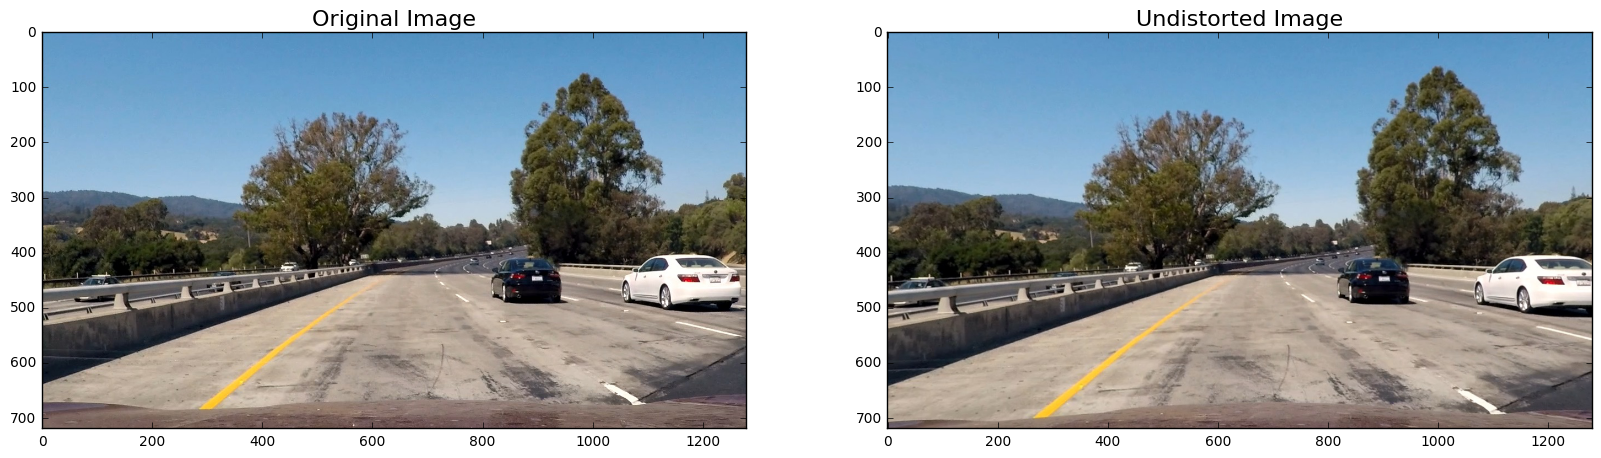

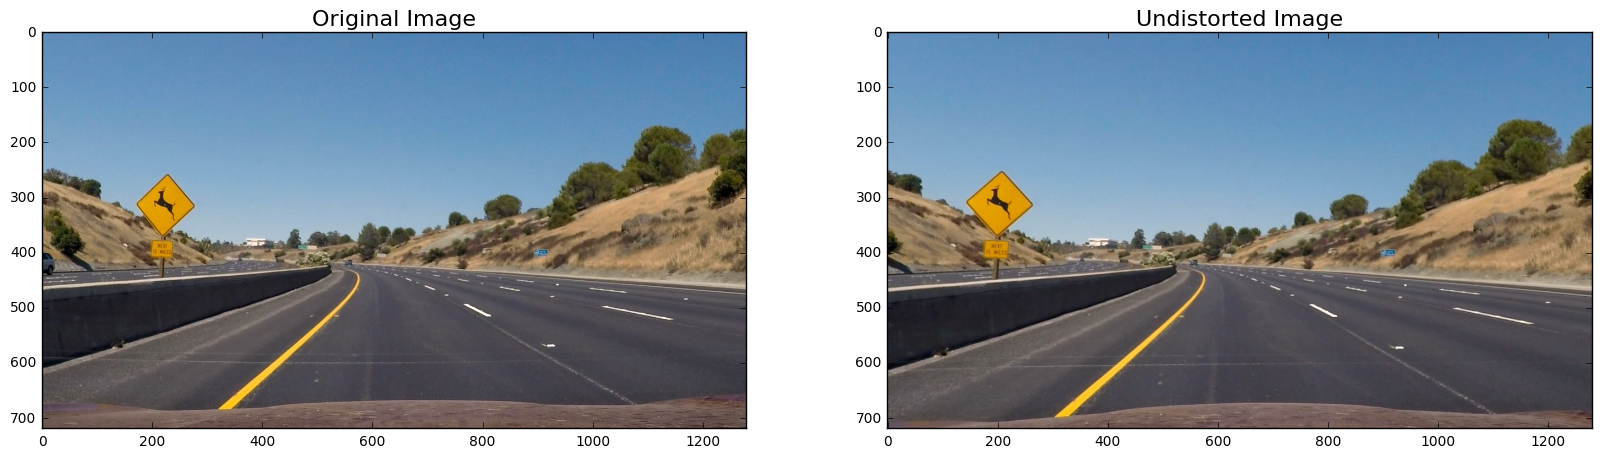

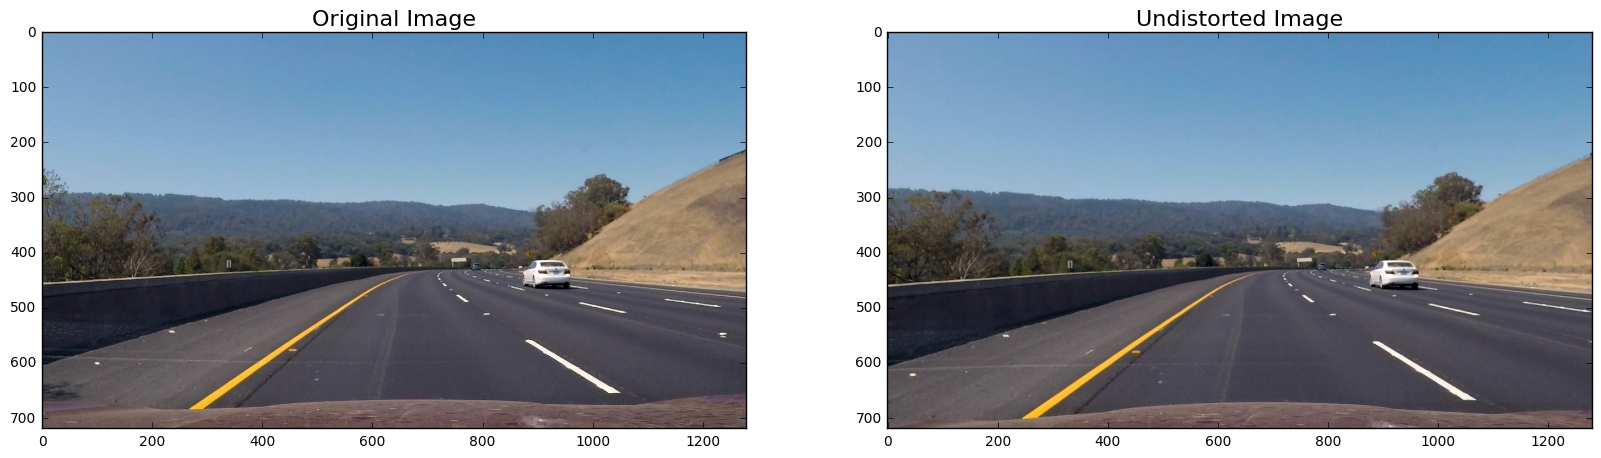

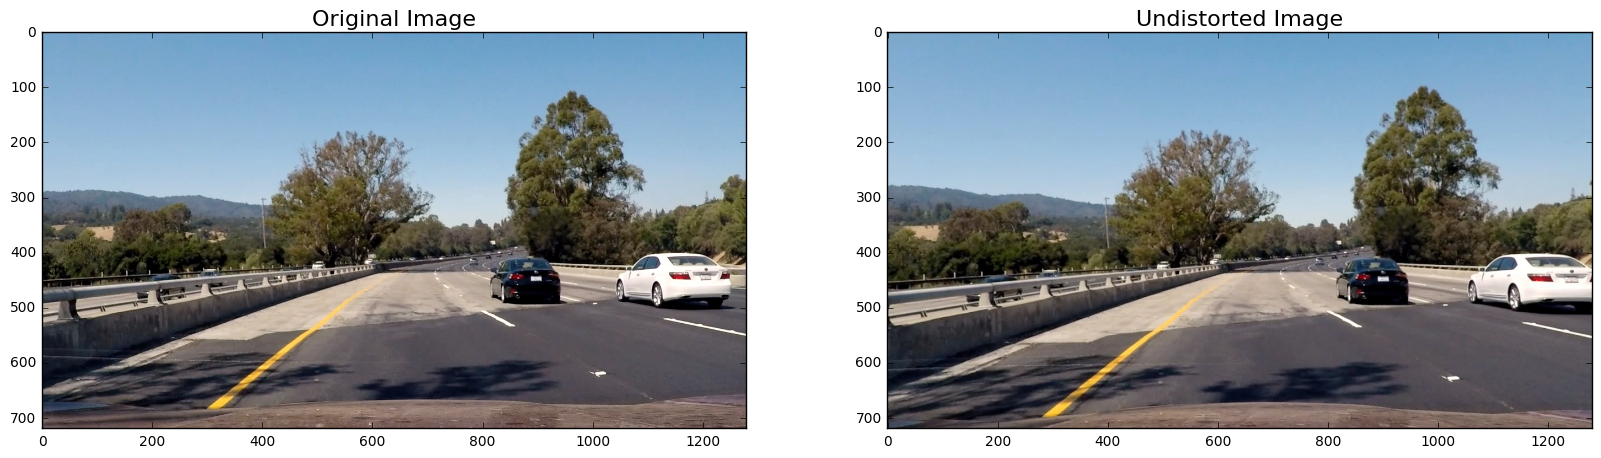

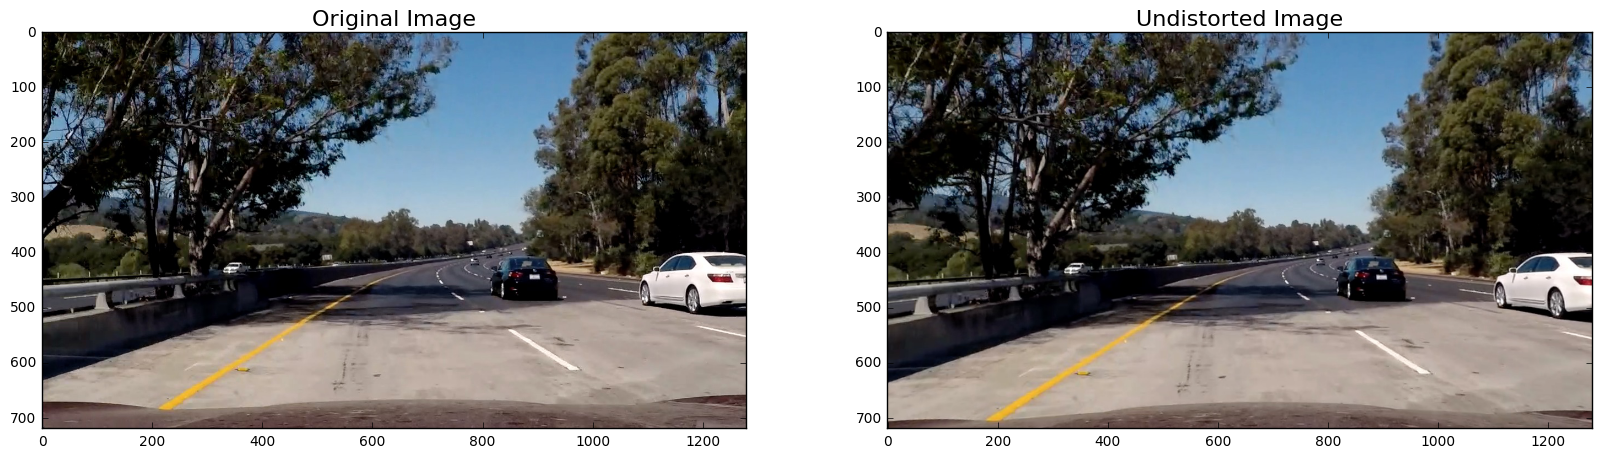

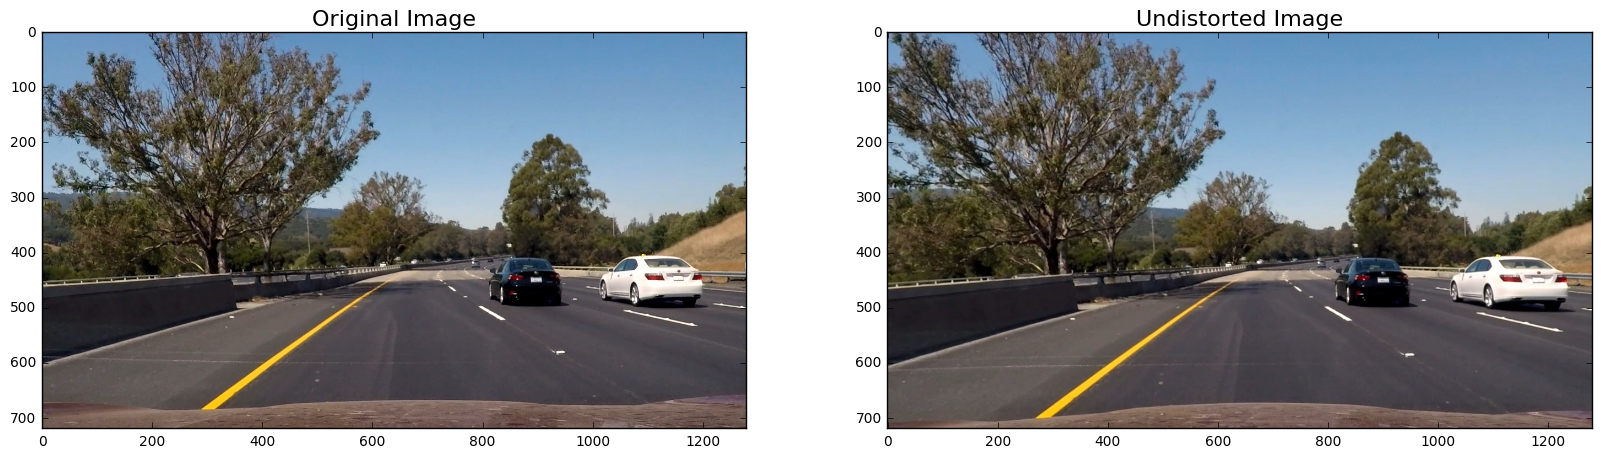

In [2]:
objpoints, imgpoints = get_cal_param('../camera_cal/calibration*.jpg', (9,6))

images = glob.glob('../test_images/test*.jpg')

# performs the camera calibration, image distortion correction 
# and returns the undistorted image
def cal_undistort(img, objpoints, imgpoints):
    # Use cv2.calibrateCamera() and cv2.undistort()
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(
        objpoints, imgpoints, gray.shape[::-1], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

for fname in images:
    # Read in an image
    img = mpimg.imread(fname)

    undistorted = cal_undistort(img, objpoints, imgpoints)
    
    sub_plt(img, undistorted, 'Original Image', 'Undistorted Image')

## Lane line detection on a straight road

** Undistort Test Image **

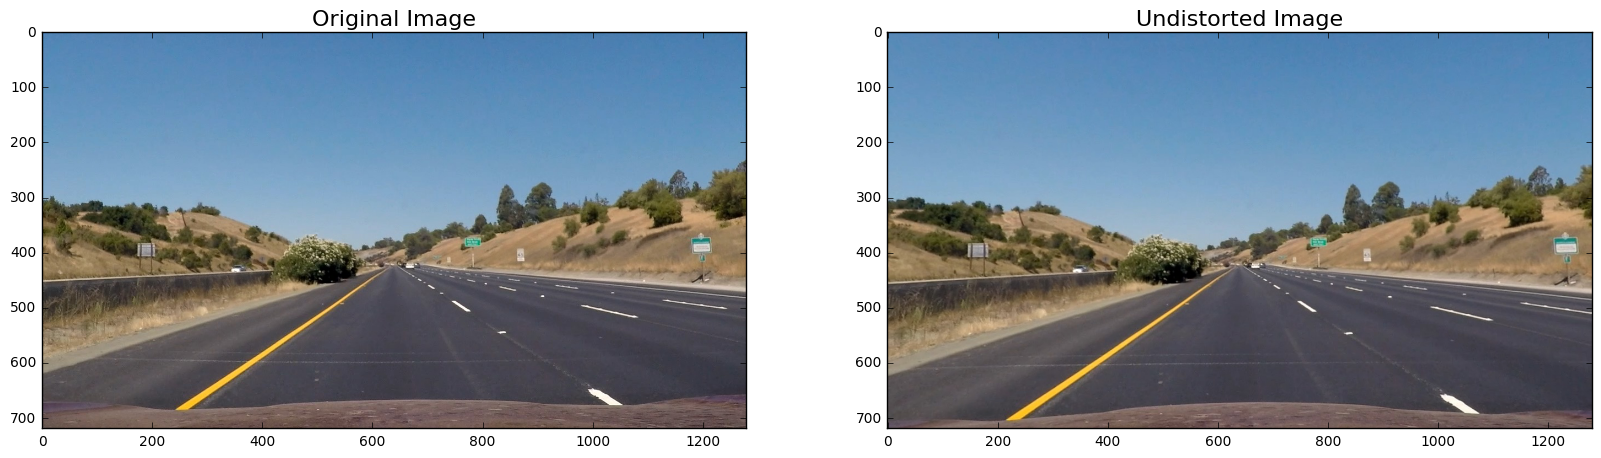

In [3]:
# Get image of straight road
image = mpimg.imread('../test_images/straight_lines1.jpg')

# Calibrate camera and undistor image
undistorted = cal_undistort(image, objpoints, imgpoints)

# display original and undistorted images
sub_plt(image, undistorted, 'Original Image', 'Undistorted Image')

** Set and Display Source Image Points **

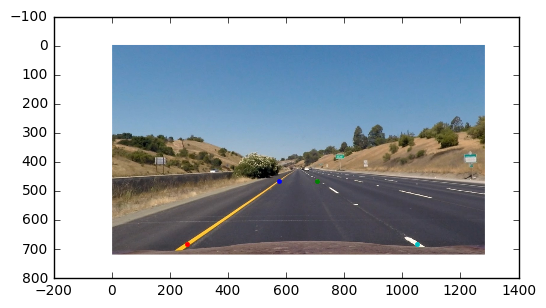

In [39]:
# Source image points
plt.imshow(undistorted)

# Image dimentions array
img_size = np.shape(undistorted)

# Order: top left, bottom left, bottom right, top right
src = np.float32([(575,464),
                  (707,464), 
                  (258,682), 
                  (1049,682)])

# format is in x, y, dot
plt.plot(src[0][0], src[0][1], '.') 
plt.plot(src[1][0], src[1][1], '.') 
plt.plot(src[2][0], src[2][1], '.') 
plt.plot(src[3][0], src[3][1], '.') 

** Perspective Transform Function **

In [37]:
def warp(img, src, dst):
    
    # Define calibration box in source (original) and destination (desired or waped) coordinates
    img_size = (img.shape[1], img.shape[0])
    
    # Four source coordinates
    src = np.float32(src)
    
    # Four desired coordinates
    dst = np.float32(dst)
    
    # Compute the perspective transform, M
    M = cv2.getPerspectiveTransform(src, dst)
    
    # Compute the inverse also by swapping the input parameters
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    # create warped image - uses linear interpolation
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    
    return warped, Minv

** Set and Visualize Destination Points for Perspective Tranform **

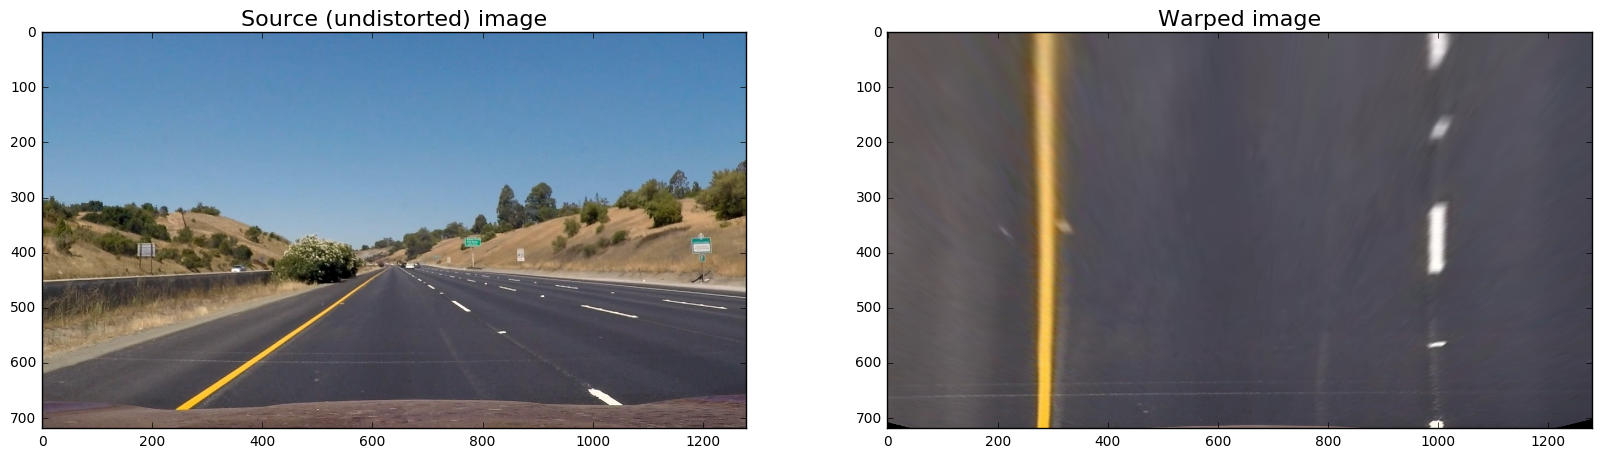

In [48]:
# Order: top left, bottom left, bottom right, top right
dst = np.float32([[280, 0],
                  [img_size[1] - 280, 0],
                  [280, img_size[0]],
                  [img_size[1] - 280, img_size[0]]])

# Get perspective transform
warped, Minv  = warp(undistorted, src, dst)

# Visualize undistorted image and warped image
sub_plt(image, warped, 'Source (undistorted) image', 'Warped image')

** Pipeline Function **

In [7]:
def pipeline(img, plt=False):
    # Add Guassian blur to remove noise
    img = cv2.GaussianBlur(img, (5, 5), 0)
    
    # Convert to HLS color space and separate the S channel
    # Note: img is the undistorted image
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]

    # Grayscale image
    # NOTE: we already saw that standard grayscaling lost color information for the lane lines
    # Explore gradients in other colors spaces / color channels to see what might work better
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold x gradient
    thresh_min = 20
    thresh_max = 100
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Threshold color channel
    s_thresh_min = 170
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    
    # Add Guassian blur to remove the left over noise
    combined_binary = cv2.GaussianBlur(combined_binary, (5, 5), 0)
    
    if plt:
        return color_binary, combined_binary
    else:
        return combined_binary

** Visualize Pipeline **

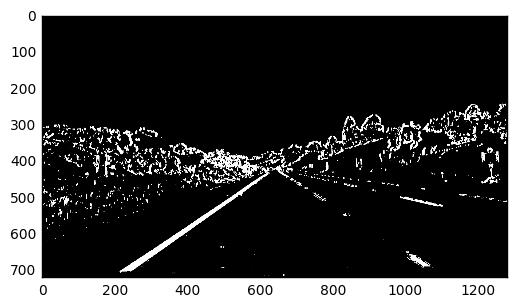

In [49]:
# Get the color and combined binary image from the undistorted image
color_binary, combined_binary = pipeline(undistorted, True)

# Plotting thresholded images
# sub_plt(color_binary, combined_binary,
#         'Stacked thresholds', 
#         'Combined S channel and gradient thresholds',
#        cmap2='gray')
plt.imshow(combined_binary, cmap='gray')

** Visualize warped pipeline **

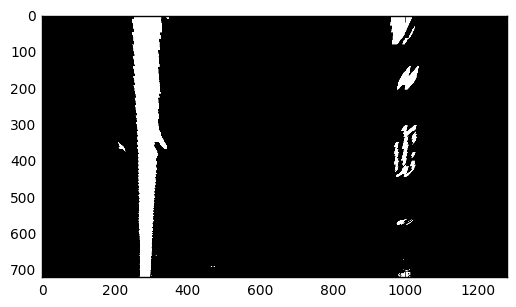

In [9]:
# Warp the combined binary image 
binary_warped, _ = warp(combined_binary, src, dst)

# Display image
plt.imshow(binary_warped, cmap='gray')

/Users/mac/anaconda2/envs/python3/lib/python3.5/site-packages/ipykernel/__main__.py:2: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  from ipykernel import kernelapp as app


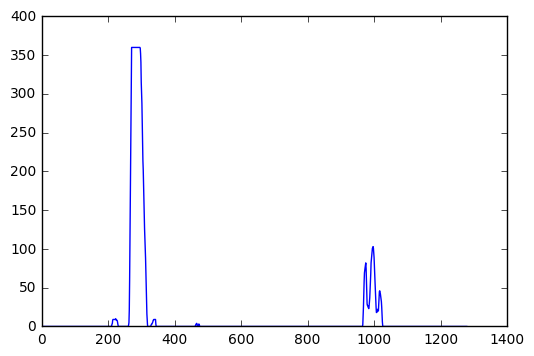

In [10]:
# Plot peaks (lanes) in a Histogram
histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
plt.plot(histogram)

## Implement Sliding Windows and Fit a Polynomial

In [11]:
def sliding_windows(binary_warped, plt=False):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
    
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows.
    nwindows = 10
    
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Set the width of the windows +/- margin
    margin = 90
    
    # Set minimum number of pixels found to recenter window
    minpix = 50
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    if plt:
        return out_img, nonzerox, nonzeroy, left_lane_inds, right_lane_inds, left_fit, right_fit
    else:
        return left_fit, right_fit

In [12]:
def poly_fit_average(binary_warped, left_fit_avg, right_fit_avg):
    # Identify the x and y positions of all nonzero pixels in the imagenonzero = binary_warped.nonzero()
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Set the width of the windows +/- margin
    margin = 90
    
    # Identify the nonzero pixels in x and y within the window and based on the left and right lane aberage
    left_lane_inds = ((nonzerox > (left_fit_avg[0]*(nonzeroy**2) + left_fit_avg[1]*nonzeroy + left_fit_avg[2] - margin)) & 
                      (nonzerox < (left_fit_avg[0]*(nonzeroy**2) + left_fit_avg[1]*nonzeroy + left_fit_avg[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit_avg[0]*(nonzeroy**2) + right_fit_avg[1]*nonzeroy + right_fit_avg[2] - margin)) & 
                       (nonzerox < (right_fit_avg[0]*(nonzeroy**2) + right_fit_avg[1]*nonzeroy + right_fit_avg[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    if len(leftx) != 0 and len(rightx) != 0:
        # Fit a second order polynomial to each
        left_fit_new = np.polyfit(lefty, leftx, 2)
        right_fit_new = np.polyfit(righty, rightx, 2)
    else:
        # Fall back to sliding windows
        left_fit_new, right_fit_new = sliding_windows(binary_warped)
        
    return left_fit_new, right_fit_new

** Visualize Sliding Windows and Fit a Polynomial **

/Users/mac/anaconda2/envs/python3/lib/python3.5/site-packages/ipykernel/__main__.py:3: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  app.launch_new_instance()


(720, 0)

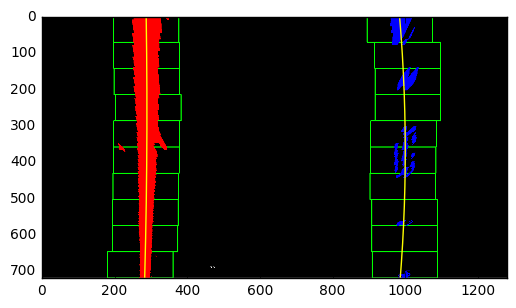

In [13]:
# Get parameters from sliding windows 
out_img, nonzerox, nonzeroy, left_lane_inds, right_lane_inds, left_fit, right_fit = sliding_windows(binary_warped, True)

# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

** Search in a Margin Around the Previous Line Position **

In [14]:
def line_search(binary_warped, left_fit, right_fit, plt=False):
    # We now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    if plt:
        return margin, ploty, left_fitx, right_fitx
    else:
        return ploty, left_fitx, right_fitx

** Shade Green the Area Where We Searched for the Line **

(720, 0)

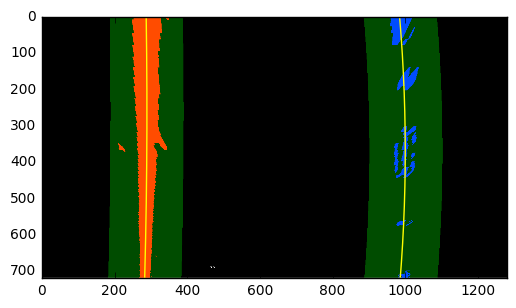

In [15]:
# Get parameters from line search
margin, ploty, left_fitx, right_fitx = line_search(binary_warped, left_fit, right_fit, True)

# Create an image to draw on and an image to show the selection window
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

## Draw Measurements Back down onto the Road

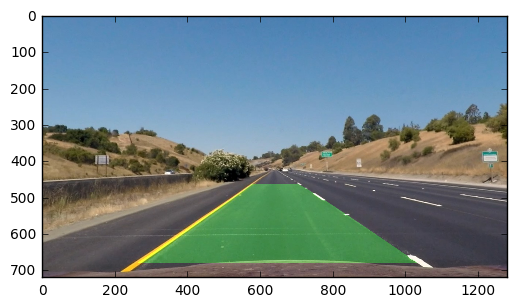

In [16]:
def draw_lines(image, binary_warped, Minv, ploty, left_fitx, right_fitx, undistorted):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    
    # Combine the result with the original image
    result = cv2.addWeighted(undistorted, 1, newwarp, 0.3, 0)

    return result

result = draw_lines(image, binary_warped, Minv, ploty, left_fitx, right_fitx, undistorted)

plt.imshow(result)

## Test on Videos

In [22]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

** Puting Eveything Together **

In [29]:
def wraper(frames): 
    myLeftFitBin = deque(maxlen=frames)
    myRightFitBin = deque(maxlen=frames)
    weights = np.arange(1, frames + 1)/frames
    
    def process_image(image):
        """ NOTE: The output you return should be a color image (3 channel) for processing video below """
    
        # Set local variable to the global variables
        left_fit_bin = myLeftFitBin
        right_fit_bin = myRightFitBin
    
        # Calibrate camera and undistort the image
        undistorted = cal_undistort(image, objpoints, imgpoints)
    
        # Combined S channel and gradient thresholds on undistorted image 
        combined_binary = pipeline(undistorted)
    
        # Warped combined binary image only showing the lane
        binary_warped, Minv = warp(combined_binary, src, dst)
    
        # Only use sliding windows every n number of frames
        if len(left_fit_bin) == 0 and len(right_fit_bin) == 0:
            # Find lanes by using sliding windows, followed by fitting a polynomial
            left_fit, right_fit = sliding_windows(binary_warped)
            
        else:
            # Fit a polynomial based on the rolling average of the last n number of frames
            left_fit, right_fit = poly_fit_average(binary_warped, 
                                                   np.average(left_fit_bin, 0, weights[-len(left_fit_bin):]), 
                                                   np.average(right_fit_bin, 0, weights[-len(right_fit_bin):]))
        
        # Append new frame left and right fit
        # deque is a Last in First out, so no need to reset
        left_fit_bin = left_fit_bin.append(left_fit)
        right_fit_bin = right_fit_bin.append(right_fit)
        
        # Search for lane line
        ploty, left_fitx, right_fitx = line_search(binary_warped, left_fit, right_fit)
    
        # Draw detected lane
        result = draw_lines(image, binary_warped, Minv, ploty, left_fitx, right_fitx, undistorted)
        
        return result
    
    return process_image

** Get Input Video and Write Modified Output Video **

In [30]:
# Initialize previous frame
left_fit_prev, right_fit_prev = None, None

# Video ouput with lane line detection
project_output = 'project_output.mp4'

# Input test video 
clip1 = VideoFileClip("../project_video.mp4")

white_clip = clip1.fl_image(wraper(30)) #NOTE: this function expects color images!!
%time white_clip.write_videofile(project_output, audio=False)

1
[MoviePy] >>>> Building video project_output.mp4
[MoviePy] Writing video project_output.mp4



  0%|          | 1/1261 [00:00<13:09,  1.60it/s]

2



  0%|          | 2/1261 [00:01<13:32,  1.55it/s]

3



  0%|          | 3/1261 [00:02<14:03,  1.49it/s]

4



  0%|          | 4/1261 [00:02<14:12,  1.47it/s]

5



  0%|          | 5/1261 [00:03<14:01,  1.49it/s]

6



  0%|          | 6/1261 [00:04<13:41,  1.53it/s]

7



  1%|          | 7/1261 [00:04<13:30,  1.55it/s]

8



  1%|          | 8/1261 [00:05<13:19,  1.57it/s]

9



  1%|          | 9/1261 [00:05<13:13,  1.58it/s]

10



  1%|          | 10/1261 [00:06<13:08,  1.59it/s]

11



  1%|          | 11/1261 [00:07<13:08,  1.59it/s]

12



  1%|          | 12/1261 [00:07<13:08,  1.58it/s]

13



  1%|          | 13/1261 [00:08<13:08,  1.58it/s]

14



  1%|          | 14/1261 [00:09<13:05,  1.59it/s]

15



  1%|          | 15/1261 [00:09<13:04,  1.59it/s]

16



  1%|▏         | 16/1261 [00:10<13:01,  1.59it/s]

17



  1%|▏         | 17/1261 [00:10<12:59,  1.60it/s]

18



  1%|▏         | 18/1261 [00:11<12:55,  1.60it/s]

19



  2%|▏         | 19/1261 [00:12<12:52,  1.61it/s]

20



  2%|▏         | 20/1261 [00:12<12:52,  1.61it/s]

21



  2%|▏         | 21/1261 [00:13<12:59,  1.59it/s]

22



  2%|▏         | 22/1261 [00:14<12:55,  1.60it/s]

23



  2%|▏         | 23/1261 [00:14<12:54,  1.60it/s]

24



  2%|▏         | 24/1261 [00:15<12:58,  1.59it/s]

25



  2%|▏         | 25/1261 [00:15<12:58,  1.59it/s]

26



  2%|▏         | 26/1261 [00:16<13:08,  1.57it/s]

27



  2%|▏         | 27/1261 [00:17<13:29,  1.53it/s]

28



  2%|▏         | 28/1261 [00:17<13:40,  1.50it/s]

29



  2%|▏         | 29/1261 [00:18<14:32,  1.41it/s]

30



  2%|▏         | 30/1261 [00:19<14:46,  1.39it/s]

30



  2%|▏         | 31/1261 [00:20<14:52,  1.38it/s]

30



  3%|▎         | 32/1261 [00:20<14:32,  1.41it/s]

30



  3%|▎         | 33/1261 [00:21<14:08,  1.45it/s]

30



  3%|▎         | 34/1261 [00:22<13:46,  1.48it/s]

30



  3%|▎         | 35/1261 [00:22<13:28,  1.52it/s]

30



  3%|▎         | 36/1261 [00:23<13:17,  1.54it/s]

30



  3%|▎         | 37/1261 [00:24<13:08,  1.55it/s]

30



  3%|▎         | 38/1261 [00:24<12:59,  1.57it/s]

30



  3%|▎         | 39/1261 [00:25<13:01,  1.56it/s]

30



  3%|▎         | 40/1261 [00:26<13:19,  1.53it/s]

30



  3%|▎         | 41/1261 [00:26<13:31,  1.50it/s]

30



  3%|▎         | 42/1261 [00:27<13:18,  1.53it/s]

30



  3%|▎         | 43/1261 [00:28<13:38,  1.49it/s]

30



  3%|▎         | 44/1261 [00:28<13:27,  1.51it/s]

30



  4%|▎         | 45/1261 [00:29<13:23,  1.51it/s]

30



  4%|▎         | 46/1261 [00:30<13:24,  1.51it/s]

30



  4%|▎         | 47/1261 [00:30<13:35,  1.49it/s]

30



  4%|▍         | 48/1261 [00:31<13:34,  1.49it/s]

30



  4%|▍         | 49/1261 [00:32<13:19,  1.52it/s]

30



  4%|▍         | 50/1261 [00:32<13:14,  1.52it/s]

30



  4%|▍         | 51/1261 [00:33<13:10,  1.53it/s]

30



  4%|▍         | 52/1261 [00:34<13:14,  1.52it/s]

30



  4%|▍         | 53/1261 [00:34<13:18,  1.51it/s]

30



  4%|▍         | 54/1261 [00:35<13:21,  1.51it/s]

30



  4%|▍         | 55/1261 [00:36<13:21,  1.50it/s]

30



  4%|▍         | 56/1261 [00:36<14:10,  1.42it/s]

30



  5%|▍         | 57/1261 [00:37<14:29,  1.38it/s]

30



  5%|▍         | 58/1261 [00:38<14:48,  1.35it/s]

30



  5%|▍         | 59/1261 [00:39<14:48,  1.35it/s]

30



  5%|▍         | 60/1261 [00:39<14:39,  1.37it/s]

30



  5%|▍         | 61/1261 [00:40<14:23,  1.39it/s]

30



  5%|▍         | 62/1261 [00:41<14:11,  1.41it/s]

30



  5%|▍         | 63/1261 [00:41<14:08,  1.41it/s]

30



  5%|▌         | 64/1261 [00:42<14:20,  1.39it/s]

30



  5%|▌         | 65/1261 [00:43<14:17,  1.39it/s]

30



  5%|▌         | 66/1261 [00:44<14:27,  1.38it/s]

30



  5%|▌         | 67/1261 [00:44<14:54,  1.33it/s]

30



  5%|▌         | 68/1261 [00:45<14:44,  1.35it/s]

30



  5%|▌         | 69/1261 [00:46<14:26,  1.38it/s]

30



  6%|▌         | 70/1261 [00:46<14:12,  1.40it/s]

30



  6%|▌         | 71/1261 [00:47<13:57,  1.42it/s]

30



  6%|▌         | 72/1261 [00:48<13:49,  1.43it/s]

30



  6%|▌         | 73/1261 [00:49<14:32,  1.36it/s]

30



  6%|▌         | 74/1261 [00:49<13:55,  1.42it/s]

30



  6%|▌         | 75/1261 [00:50<13:30,  1.46it/s]

30



  6%|▌         | 76/1261 [00:51<13:18,  1.48it/s]

30



  6%|▌         | 77/1261 [00:51<13:00,  1.52it/s]

30



  6%|▌         | 78/1261 [00:52<12:48,  1.54it/s]

30



  6%|▋         | 79/1261 [00:52<12:43,  1.55it/s]

30



  6%|▋         | 80/1261 [00:53<12:42,  1.55it/s]

30



  6%|▋         | 81/1261 [00:54<12:39,  1.55it/s]

30



  7%|▋         | 82/1261 [00:54<12:41,  1.55it/s]

30



  7%|▋         | 83/1261 [00:55<12:33,  1.56it/s]

30



  7%|▋         | 84/1261 [00:56<12:34,  1.56it/s]

30



  7%|▋         | 85/1261 [00:56<12:28,  1.57it/s]

30



  7%|▋         | 86/1261 [00:57<12:25,  1.58it/s]

30



  7%|▋         | 87/1261 [00:58<12:22,  1.58it/s]

30



  7%|▋         | 88/1261 [00:58<12:35,  1.55it/s]

30



  7%|▋         | 89/1261 [00:59<12:33,  1.56it/s]

30



  7%|▋         | 90/1261 [01:00<12:29,  1.56it/s]

30



  7%|▋         | 91/1261 [01:00<12:27,  1.56it/s]

30



  7%|▋         | 92/1261 [01:01<12:29,  1.56it/s]

30



  7%|▋         | 93/1261 [01:01<12:24,  1.57it/s]

30



  7%|▋         | 94/1261 [01:02<12:22,  1.57it/s]

30



  8%|▊         | 95/1261 [01:03<12:22,  1.57it/s]

30



  8%|▊         | 96/1261 [01:03<12:27,  1.56it/s]

30



  8%|▊         | 97/1261 [01:04<12:25,  1.56it/s]

30



  8%|▊         | 98/1261 [01:05<12:19,  1.57it/s]

30



  8%|▊         | 99/1261 [01:05<12:41,  1.53it/s]

30



  8%|▊         | 100/1261 [01:06<13:05,  1.48it/s]

30



  8%|▊         | 101/1261 [01:07<13:16,  1.46it/s]

30



  8%|▊         | 102/1261 [01:08<13:48,  1.40it/s]

30



  8%|▊         | 103/1261 [01:08<13:40,  1.41it/s]

30



  8%|▊         | 104/1261 [01:09<13:54,  1.39it/s]

30



  8%|▊         | 105/1261 [01:10<14:09,  1.36it/s]

30



  8%|▊         | 106/1261 [01:11<14:21,  1.34it/s]

30



  8%|▊         | 107/1261 [01:11<14:00,  1.37it/s]

30



  9%|▊         | 108/1261 [01:12<13:48,  1.39it/s]

30



  9%|▊         | 109/1261 [01:13<13:16,  1.45it/s]

30



  9%|▊         | 110/1261 [01:13<12:49,  1.50it/s]

30



  9%|▉         | 111/1261 [01:14<12:37,  1.52it/s]

30



  9%|▉         | 112/1261 [01:15<13:09,  1.46it/s]

30



  9%|▉         | 113/1261 [01:15<13:45,  1.39it/s]

30



  9%|▉         | 114/1261 [01:16<13:30,  1.42it/s]

30



  9%|▉         | 115/1261 [01:17<13:18,  1.44it/s]

30



  9%|▉         | 116/1261 [01:17<12:54,  1.48it/s]

30



  9%|▉         | 117/1261 [01:18<12:40,  1.50it/s]

30



  9%|▉         | 118/1261 [01:19<12:26,  1.53it/s]

30



  9%|▉         | 119/1261 [01:19<12:19,  1.54it/s]

30



 10%|▉         | 120/1261 [01:20<12:14,  1.55it/s]

30



 10%|▉         | 121/1261 [01:20<12:09,  1.56it/s]

30



 10%|▉         | 122/1261 [01:21<12:06,  1.57it/s]

30



 10%|▉         | 123/1261 [01:22<12:31,  1.51it/s]

30



 10%|▉         | 124/1261 [01:23<12:43,  1.49it/s]

30



 10%|▉         | 125/1261 [01:23<13:16,  1.43it/s]

30



 10%|▉         | 126/1261 [01:24<13:07,  1.44it/s]

30



 10%|█         | 127/1261 [01:25<13:01,  1.45it/s]

30



 10%|█         | 128/1261 [01:25<12:40,  1.49it/s]

30



 10%|█         | 129/1261 [01:26<12:27,  1.51it/s]

30



 10%|█         | 130/1261 [01:27<12:11,  1.55it/s]

30



 10%|█         | 131/1261 [01:27<12:03,  1.56it/s]

30



 10%|█         | 132/1261 [01:28<12:31,  1.50it/s]

30



 11%|█         | 133/1261 [01:29<12:39,  1.49it/s]

30



 11%|█         | 134/1261 [01:29<12:49,  1.46it/s]

30



 11%|█         | 135/1261 [01:30<13:16,  1.41it/s]

30



 11%|█         | 136/1261 [01:31<13:27,  1.39it/s]

30



 11%|█         | 137/1261 [01:32<13:32,  1.38it/s]

30



 11%|█         | 138/1261 [01:32<13:39,  1.37it/s]

30



 11%|█         | 139/1261 [01:33<13:34,  1.38it/s]

30



 11%|█         | 140/1261 [01:34<13:16,  1.41it/s]

30



 11%|█         | 141/1261 [01:34<13:08,  1.42it/s]

30



 11%|█▏        | 142/1261 [01:35<12:45,  1.46it/s]

30



 11%|█▏        | 143/1261 [01:36<12:26,  1.50it/s]

30



 11%|█▏        | 144/1261 [01:36<12:17,  1.51it/s]

30



 11%|█▏        | 145/1261 [01:37<12:23,  1.50it/s]

30



 12%|█▏        | 146/1261 [01:38<12:18,  1.51it/s]

30



 12%|█▏        | 147/1261 [01:38<12:29,  1.49it/s]

30



 12%|█▏        | 148/1261 [01:39<12:43,  1.46it/s]

30



 12%|█▏        | 149/1261 [01:40<12:43,  1.46it/s]

30



 12%|█▏        | 150/1261 [01:40<12:42,  1.46it/s]

30



 12%|█▏        | 151/1261 [01:41<13:01,  1.42it/s]

30



 12%|█▏        | 152/1261 [01:42<12:43,  1.45it/s]

30



 12%|█▏        | 153/1261 [01:42<12:34,  1.47it/s]

30



 12%|█▏        | 154/1261 [01:43<12:30,  1.47it/s]

30



 12%|█▏        | 155/1261 [01:44<12:12,  1.51it/s]

30



 12%|█▏        | 156/1261 [01:44<12:15,  1.50it/s]

30



 12%|█▏        | 157/1261 [01:45<12:23,  1.48it/s]

30



 13%|█▎        | 158/1261 [01:46<12:16,  1.50it/s]

30



 13%|█▎        | 159/1261 [01:46<12:26,  1.48it/s]

30



 13%|█▎        | 160/1261 [01:47<12:21,  1.48it/s]

30



 13%|█▎        | 161/1261 [01:48<12:09,  1.51it/s]

30



 13%|█▎        | 162/1261 [01:48<12:00,  1.53it/s]

30



 13%|█▎        | 163/1261 [01:49<11:53,  1.54it/s]

30



 13%|█▎        | 164/1261 [01:50<11:48,  1.55it/s]

30



 13%|█▎        | 165/1261 [01:50<11:48,  1.55it/s]

30



 13%|█▎        | 166/1261 [01:51<12:04,  1.51it/s]

30



 13%|█▎        | 167/1261 [01:52<12:17,  1.48it/s]

30



 13%|█▎        | 168/1261 [01:52<12:31,  1.45it/s]

30



 13%|█▎        | 169/1261 [01:53<12:56,  1.41it/s]

30



 13%|█▎        | 170/1261 [01:54<12:59,  1.40it/s]

30



 14%|█▎        | 171/1261 [01:55<13:08,  1.38it/s]

30



 14%|█▎        | 172/1261 [01:55<13:19,  1.36it/s]

30



 14%|█▎        | 173/1261 [01:56<13:15,  1.37it/s]

30



 14%|█▍        | 174/1261 [01:57<13:29,  1.34it/s]

30



 14%|█▍        | 175/1261 [01:58<13:42,  1.32it/s]

30



 14%|█▍        | 176/1261 [01:58<13:48,  1.31it/s]

30



 14%|█▍        | 177/1261 [01:59<13:55,  1.30it/s]

30



 14%|█▍        | 178/1261 [02:00<13:42,  1.32it/s]

30



 14%|█▍        | 179/1261 [02:01<13:19,  1.35it/s]

30



 14%|█▍        | 180/1261 [02:01<13:11,  1.37it/s]

30



 14%|█▍        | 181/1261 [02:02<13:00,  1.38it/s]

30



 14%|█▍        | 182/1261 [02:03<13:02,  1.38it/s]

30



 15%|█▍        | 183/1261 [02:04<12:49,  1.40it/s]

30



 15%|█▍        | 184/1261 [02:04<12:27,  1.44it/s]

30



 15%|█▍        | 185/1261 [02:05<12:21,  1.45it/s]

30



 15%|█▍        | 186/1261 [02:05<12:03,  1.49it/s]

30



 15%|█▍        | 187/1261 [02:06<11:50,  1.51it/s]

30



 15%|█▍        | 188/1261 [02:07<11:47,  1.52it/s]

30



 15%|█▍        | 189/1261 [02:07<11:48,  1.51it/s]

30



 15%|█▌        | 190/1261 [02:08<12:19,  1.45it/s]

30



 15%|█▌        | 191/1261 [02:09<12:34,  1.42it/s]

30



 15%|█▌        | 192/1261 [02:10<12:31,  1.42it/s]

30



 15%|█▌        | 193/1261 [02:10<12:10,  1.46it/s]

30



 15%|█▌        | 194/1261 [02:11<12:03,  1.47it/s]

30



 15%|█▌        | 195/1261 [02:12<11:50,  1.50it/s]

30



 16%|█▌        | 196/1261 [02:12<11:42,  1.52it/s]

30



 16%|█▌        | 197/1261 [02:13<11:34,  1.53it/s]

30



 16%|█▌        | 198/1261 [02:14<11:30,  1.54it/s]

30



 16%|█▌        | 199/1261 [02:14<11:28,  1.54it/s]

30



 16%|█▌        | 200/1261 [02:15<11:25,  1.55it/s]

30



 16%|█▌        | 201/1261 [02:15<11:19,  1.56it/s]

30



 16%|█▌        | 202/1261 [02:16<11:35,  1.52it/s]

30



 16%|█▌        | 203/1261 [02:17<11:39,  1.51it/s]

30



 16%|█▌        | 204/1261 [02:17<11:47,  1.49it/s]

30



 16%|█▋        | 205/1261 [02:18<11:40,  1.51it/s]

30



 16%|█▋        | 206/1261 [02:19<11:35,  1.52it/s]

30



 16%|█▋        | 207/1261 [02:19<11:44,  1.50it/s]

30



 16%|█▋        | 208/1261 [02:20<11:59,  1.46it/s]

30



 17%|█▋        | 209/1261 [02:21<12:17,  1.43it/s]

30



 17%|█▋        | 210/1261 [02:22<12:20,  1.42it/s]

30



 17%|█▋        | 211/1261 [02:22<12:55,  1.35it/s]

30



 17%|█▋        | 212/1261 [02:23<12:58,  1.35it/s]

30



 17%|█▋        | 213/1261 [02:24<12:43,  1.37it/s]

30



 17%|█▋        | 214/1261 [02:25<12:34,  1.39it/s]

30



 17%|█▋        | 215/1261 [02:25<12:39,  1.38it/s]

30



 17%|█▋        | 216/1261 [02:26<12:37,  1.38it/s]

30



 17%|█▋        | 217/1261 [02:27<12:29,  1.39it/s]

30



 17%|█▋        | 218/1261 [02:27<12:30,  1.39it/s]

30



 17%|█▋        | 219/1261 [02:28<12:27,  1.39it/s]

30



 17%|█▋        | 220/1261 [02:29<12:18,  1.41it/s]

30



 18%|█▊        | 221/1261 [02:30<12:16,  1.41it/s]

30



 18%|█▊        | 222/1261 [02:30<12:17,  1.41it/s]

30



 18%|█▊        | 223/1261 [02:31<12:10,  1.42it/s]

30



 18%|█▊        | 224/1261 [02:32<12:05,  1.43it/s]

30



 18%|█▊        | 225/1261 [02:32<11:45,  1.47it/s]

30



 18%|█▊        | 226/1261 [02:33<11:33,  1.49it/s]

30



 18%|█▊        | 227/1261 [02:34<11:22,  1.51it/s]

30



 18%|█▊        | 228/1261 [02:34<11:12,  1.54it/s]

30



 18%|█▊        | 229/1261 [02:35<11:05,  1.55it/s]

30



 18%|█▊        | 230/1261 [02:36<11:00,  1.56it/s]

30



 18%|█▊        | 231/1261 [02:36<10:58,  1.56it/s]

30



 18%|█▊        | 232/1261 [02:37<10:59,  1.56it/s]

30



 18%|█▊        | 233/1261 [02:37<11:00,  1.56it/s]

30



 19%|█▊        | 234/1261 [02:38<10:58,  1.56it/s]

30



 19%|█▊        | 235/1261 [02:39<10:52,  1.57it/s]

30



 19%|█▊        | 236/1261 [02:39<10:50,  1.57it/s]

30



 19%|█▉        | 237/1261 [02:40<10:47,  1.58it/s]

30



 19%|█▉        | 238/1261 [02:41<10:44,  1.59it/s]

30



 19%|█▉        | 239/1261 [02:41<10:42,  1.59it/s]

30



 19%|█▉        | 240/1261 [02:42<10:47,  1.58it/s]

30



 19%|█▉        | 241/1261 [02:42<10:47,  1.57it/s]

30



 19%|█▉        | 242/1261 [02:43<10:45,  1.58it/s]

30



 19%|█▉        | 243/1261 [02:44<10:45,  1.58it/s]

30



 19%|█▉        | 244/1261 [02:44<10:45,  1.57it/s]

30



 19%|█▉        | 245/1261 [02:45<10:48,  1.57it/s]

30



 20%|█▉        | 246/1261 [02:46<10:49,  1.56it/s]

30



 20%|█▉        | 247/1261 [02:46<10:46,  1.57it/s]

30



 20%|█▉        | 248/1261 [02:47<10:47,  1.56it/s]

30



 20%|█▉        | 249/1261 [02:48<10:43,  1.57it/s]

30



 20%|█▉        | 250/1261 [02:48<10:40,  1.58it/s]

30



 20%|█▉        | 251/1261 [02:49<10:38,  1.58it/s]

30



 20%|█▉        | 252/1261 [02:49<10:38,  1.58it/s]

30



 20%|██        | 253/1261 [02:50<10:41,  1.57it/s]

30



 20%|██        | 254/1261 [02:51<10:39,  1.57it/s]

30



 20%|██        | 255/1261 [02:51<10:36,  1.58it/s]

30



 20%|██        | 256/1261 [02:52<10:37,  1.58it/s]

30



 20%|██        | 257/1261 [02:53<10:38,  1.57it/s]

30



 20%|██        | 258/1261 [02:53<10:36,  1.58it/s]

30



 21%|██        | 259/1261 [02:54<10:35,  1.58it/s]

30



 21%|██        | 260/1261 [02:55<10:39,  1.57it/s]

30



 21%|██        | 261/1261 [02:55<10:36,  1.57it/s]

30



 21%|██        | 262/1261 [02:56<10:34,  1.57it/s]

30



 21%|██        | 263/1261 [02:56<10:33,  1.58it/s]

30



 21%|██        | 264/1261 [02:57<10:28,  1.59it/s]

30



 21%|██        | 265/1261 [02:58<10:28,  1.59it/s]

30



 21%|██        | 266/1261 [02:58<10:35,  1.57it/s]

30



 21%|██        | 267/1261 [02:59<10:47,  1.54it/s]

30



 21%|██▏       | 268/1261 [03:00<11:15,  1.47it/s]

30



 21%|██▏       | 269/1261 [03:01<11:25,  1.45it/s]

30



 21%|██▏       | 270/1261 [03:01<11:07,  1.48it/s]

30



 21%|██▏       | 271/1261 [03:02<10:59,  1.50it/s]

30



 22%|██▏       | 272/1261 [03:02<10:53,  1.51it/s]

30



 22%|██▏       | 273/1261 [03:03<10:41,  1.54it/s]

30



 22%|██▏       | 274/1261 [03:04<10:46,  1.53it/s]

30



 22%|██▏       | 275/1261 [03:04<10:57,  1.50it/s]

30



 22%|██▏       | 276/1261 [03:05<11:08,  1.47it/s]

30



 22%|██▏       | 277/1261 [03:06<11:11,  1.47it/s]

30



 22%|██▏       | 278/1261 [03:06<10:55,  1.50it/s]

30



 22%|██▏       | 279/1261 [03:07<11:04,  1.48it/s]

30



 22%|██▏       | 280/1261 [03:08<11:07,  1.47it/s]

30



 22%|██▏       | 281/1261 [03:09<11:34,  1.41it/s]

30



 22%|██▏       | 282/1261 [03:09<11:36,  1.40it/s]

30



 22%|██▏       | 283/1261 [03:10<11:17,  1.44it/s]

30



 23%|██▎       | 284/1261 [03:11<11:11,  1.45it/s]

30



 23%|██▎       | 285/1261 [03:11<10:59,  1.48it/s]

30



 23%|██▎       | 286/1261 [03:12<10:47,  1.51it/s]

30



 23%|██▎       | 287/1261 [03:13<10:34,  1.53it/s]

30



 23%|██▎       | 288/1261 [03:13<10:31,  1.54it/s]

30



 23%|██▎       | 289/1261 [03:14<10:28,  1.55it/s]

30



 23%|██▎       | 290/1261 [03:15<10:26,  1.55it/s]

30



 23%|██▎       | 291/1261 [03:15<10:23,  1.56it/s]

30



 23%|██▎       | 292/1261 [03:16<10:22,  1.56it/s]

30



 23%|██▎       | 293/1261 [03:16<10:28,  1.54it/s]

30



 23%|██▎       | 294/1261 [03:17<10:23,  1.55it/s]

30



 23%|██▎       | 295/1261 [03:18<10:18,  1.56it/s]

30



 23%|██▎       | 296/1261 [03:18<10:16,  1.57it/s]

30



 24%|██▎       | 297/1261 [03:19<10:11,  1.58it/s]

30



 24%|██▎       | 298/1261 [03:20<10:10,  1.58it/s]

30



 24%|██▎       | 299/1261 [03:20<10:13,  1.57it/s]

30



 24%|██▍       | 300/1261 [03:21<10:14,  1.56it/s]

30



 24%|██▍       | 301/1261 [03:22<10:12,  1.57it/s]

30



 24%|██▍       | 302/1261 [03:22<10:13,  1.56it/s]

30



 24%|██▍       | 303/1261 [03:23<10:14,  1.56it/s]

30



 24%|██▍       | 304/1261 [03:23<10:11,  1.56it/s]

30



 24%|██▍       | 305/1261 [03:24<10:06,  1.58it/s]

30



 24%|██▍       | 306/1261 [03:25<10:07,  1.57it/s]

30



 24%|██▍       | 307/1261 [03:25<10:07,  1.57it/s]

30



 24%|██▍       | 308/1261 [03:26<10:07,  1.57it/s]

30



 25%|██▍       | 309/1261 [03:27<10:10,  1.56it/s]

30



 25%|██▍       | 310/1261 [03:27<10:28,  1.51it/s]

30



 25%|██▍       | 311/1261 [03:28<10:38,  1.49it/s]

30



 25%|██▍       | 312/1261 [03:29<10:36,  1.49it/s]

30



 25%|██▍       | 313/1261 [03:29<10:26,  1.51it/s]

30



 25%|██▍       | 314/1261 [03:30<10:23,  1.52it/s]

30



 25%|██▍       | 315/1261 [03:31<10:21,  1.52it/s]

30



 25%|██▌       | 316/1261 [03:31<10:13,  1.54it/s]

30



 25%|██▌       | 317/1261 [03:32<10:13,  1.54it/s]

30



 25%|██▌       | 318/1261 [03:33<10:12,  1.54it/s]

30



 25%|██▌       | 319/1261 [03:33<10:08,  1.55it/s]

30



 25%|██▌       | 320/1261 [03:34<10:15,  1.53it/s]

30



 25%|██▌       | 321/1261 [03:35<10:31,  1.49it/s]

30



 26%|██▌       | 322/1261 [03:35<10:29,  1.49it/s]

30



 26%|██▌       | 323/1261 [03:36<10:49,  1.45it/s]

30



 26%|██▌       | 324/1261 [03:37<10:39,  1.47it/s]

30



 26%|██▌       | 325/1261 [03:37<10:31,  1.48it/s]

30



 26%|██▌       | 326/1261 [03:38<10:25,  1.49it/s]

30



 26%|██▌       | 327/1261 [03:39<10:32,  1.48it/s]

30



 26%|██▌       | 328/1261 [03:39<10:36,  1.47it/s]

30



 26%|██▌       | 329/1261 [03:40<10:39,  1.46it/s]

30



 26%|██▌       | 330/1261 [03:41<10:41,  1.45it/s]

30



 26%|██▌       | 331/1261 [03:41<10:38,  1.46it/s]

30



 26%|██▋       | 332/1261 [03:42<10:41,  1.45it/s]

30



 26%|██▋       | 333/1261 [03:43<10:38,  1.45it/s]

30



 26%|██▋       | 334/1261 [03:44<10:45,  1.44it/s]

30



 27%|██▋       | 335/1261 [03:44<10:34,  1.46it/s]

30



 27%|██▋       | 336/1261 [03:45<10:17,  1.50it/s]

30



 27%|██▋       | 337/1261 [03:46<10:17,  1.50it/s]

30



 27%|██▋       | 338/1261 [03:46<10:18,  1.49it/s]

30



 27%|██▋       | 339/1261 [03:47<10:10,  1.51it/s]

30



 27%|██▋       | 340/1261 [03:47<10:03,  1.53it/s]

30



 27%|██▋       | 341/1261 [03:48<09:55,  1.54it/s]

30



 27%|██▋       | 342/1261 [03:49<09:54,  1.55it/s]

30



 27%|██▋       | 343/1261 [03:49<09:57,  1.54it/s]

30



 27%|██▋       | 344/1261 [03:50<09:50,  1.55it/s]

30



 27%|██▋       | 345/1261 [03:51<09:44,  1.57it/s]

30



 27%|██▋       | 346/1261 [03:51<09:45,  1.56it/s]

30



 28%|██▊       | 347/1261 [03:52<09:50,  1.55it/s]

30



 28%|██▊       | 348/1261 [03:53<09:55,  1.53it/s]

30



 28%|██▊       | 349/1261 [03:53<10:08,  1.50it/s]

30



 28%|██▊       | 350/1261 [03:54<10:39,  1.42it/s]

30



 28%|██▊       | 351/1261 [03:55<10:33,  1.44it/s]

30



 28%|██▊       | 352/1261 [03:55<10:26,  1.45it/s]

30



 28%|██▊       | 353/1261 [03:56<10:28,  1.44it/s]

30



 28%|██▊       | 354/1261 [03:57<10:27,  1.45it/s]

30



 28%|██▊       | 355/1261 [03:58<10:20,  1.46it/s]

30



 28%|██▊       | 356/1261 [03:58<10:10,  1.48it/s]

30



 28%|██▊       | 357/1261 [03:59<10:21,  1.45it/s]

30



 28%|██▊       | 358/1261 [04:00<10:19,  1.46it/s]

30



 28%|██▊       | 359/1261 [04:00<10:27,  1.44it/s]

30



 29%|██▊       | 360/1261 [04:01<10:34,  1.42it/s]

30



 29%|██▊       | 361/1261 [04:02<10:30,  1.43it/s]

30



 29%|██▊       | 362/1261 [04:02<10:35,  1.41it/s]

30



 29%|██▉       | 363/1261 [04:03<10:31,  1.42it/s]

30



 29%|██▉       | 364/1261 [04:04<10:26,  1.43it/s]

30



 29%|██▉       | 365/1261 [04:04<10:14,  1.46it/s]

30



 29%|██▉       | 366/1261 [04:05<10:16,  1.45it/s]

30



 29%|██▉       | 367/1261 [04:06<10:08,  1.47it/s]

30



 29%|██▉       | 368/1261 [04:06<10:01,  1.49it/s]

30



 29%|██▉       | 369/1261 [04:07<09:55,  1.50it/s]

30



 29%|██▉       | 370/1261 [04:08<10:02,  1.48it/s]

30



 29%|██▉       | 371/1261 [04:09<10:08,  1.46it/s]

30



 30%|██▉       | 372/1261 [04:09<10:28,  1.42it/s]

30



 30%|██▉       | 373/1261 [04:10<10:35,  1.40it/s]

30



 30%|██▉       | 374/1261 [04:11<10:28,  1.41it/s]

30



 30%|██▉       | 375/1261 [04:12<10:50,  1.36it/s]

30



 30%|██▉       | 376/1261 [04:12<10:45,  1.37it/s]

30



 30%|██▉       | 377/1261 [04:13<10:26,  1.41it/s]

30



 30%|██▉       | 378/1261 [04:14<10:21,  1.42it/s]

30



 30%|███       | 379/1261 [04:14<10:19,  1.42it/s]

30



 30%|███       | 380/1261 [04:15<10:10,  1.44it/s]

30



 30%|███       | 381/1261 [04:16<10:01,  1.46it/s]

30



 30%|███       | 382/1261 [04:16<10:09,  1.44it/s]

30



 30%|███       | 383/1261 [04:17<10:07,  1.44it/s]

30



 30%|███       | 384/1261 [04:18<10:38,  1.37it/s]

30



 31%|███       | 385/1261 [04:19<10:52,  1.34it/s]

30



 31%|███       | 386/1261 [04:19<10:49,  1.35it/s]

30



 31%|███       | 387/1261 [04:20<10:58,  1.33it/s]

30



 31%|███       | 388/1261 [04:21<10:41,  1.36it/s]

30



 31%|███       | 389/1261 [04:21<10:21,  1.40it/s]

30



 31%|███       | 390/1261 [04:22<10:21,  1.40it/s]

30



 31%|███       | 391/1261 [04:23<10:15,  1.41it/s]

30



 31%|███       | 392/1261 [04:24<09:58,  1.45it/s]

30



 31%|███       | 393/1261 [04:24<09:43,  1.49it/s]

30



 31%|███       | 394/1261 [04:25<09:51,  1.47it/s]

30



 31%|███▏      | 395/1261 [04:26<10:00,  1.44it/s]

30



 31%|███▏      | 396/1261 [04:26<10:21,  1.39it/s]

30



 31%|███▏      | 397/1261 [04:27<10:13,  1.41it/s]

30



 32%|███▏      | 398/1261 [04:28<10:09,  1.42it/s]

30



 32%|███▏      | 399/1261 [04:28<09:57,  1.44it/s]

30



 32%|███▏      | 400/1261 [04:29<09:57,  1.44it/s]

30



 32%|███▏      | 401/1261 [04:30<10:03,  1.43it/s]

30



 32%|███▏      | 402/1261 [04:31<10:02,  1.42it/s]

30



 32%|███▏      | 403/1261 [04:31<09:54,  1.44it/s]

30



 32%|███▏      | 404/1261 [04:32<09:56,  1.44it/s]

30



 32%|███▏      | 405/1261 [04:33<09:39,  1.48it/s]

30



 32%|███▏      | 406/1261 [04:33<09:31,  1.50it/s]

30



 32%|███▏      | 407/1261 [04:34<09:24,  1.51it/s]

30



 32%|███▏      | 408/1261 [04:34<09:20,  1.52it/s]

30



 32%|███▏      | 409/1261 [04:35<09:16,  1.53it/s]

30



 33%|███▎      | 410/1261 [04:36<09:13,  1.54it/s]

30



 33%|███▎      | 411/1261 [04:36<09:10,  1.54it/s]

30



 33%|███▎      | 412/1261 [04:37<09:05,  1.56it/s]

30



 33%|███▎      | 413/1261 [04:38<09:05,  1.56it/s]

30



 33%|███▎      | 414/1261 [04:38<09:06,  1.55it/s]

30



 33%|███▎      | 415/1261 [04:39<09:00,  1.56it/s]

30



 33%|███▎      | 416/1261 [04:40<08:57,  1.57it/s]

30



 33%|███▎      | 417/1261 [04:40<08:57,  1.57it/s]

30



 33%|███▎      | 418/1261 [04:41<09:02,  1.55it/s]

30



 33%|███▎      | 419/1261 [04:42<09:03,  1.55it/s]

30



 33%|███▎      | 420/1261 [04:42<09:01,  1.55it/s]

30



 33%|███▎      | 421/1261 [04:43<09:03,  1.55it/s]

30



 33%|███▎      | 422/1261 [04:44<09:05,  1.54it/s]

30



 34%|███▎      | 423/1261 [04:44<09:04,  1.54it/s]

30



 34%|███▎      | 424/1261 [04:45<09:00,  1.55it/s]

30



 34%|███▎      | 425/1261 [04:45<08:56,  1.56it/s]

30



 34%|███▍      | 426/1261 [04:46<08:56,  1.56it/s]

30



 34%|███▍      | 427/1261 [04:47<08:55,  1.56it/s]

30



 34%|███▍      | 428/1261 [04:47<08:57,  1.55it/s]

30



 34%|███▍      | 429/1261 [04:48<09:01,  1.54it/s]

30



 34%|███▍      | 430/1261 [04:49<08:59,  1.54it/s]

30



 34%|███▍      | 431/1261 [04:49<08:55,  1.55it/s]

30



 34%|███▍      | 432/1261 [04:50<08:54,  1.55it/s]

30



 34%|███▍      | 433/1261 [04:51<08:49,  1.56it/s]

30



 34%|███▍      | 434/1261 [04:51<08:51,  1.56it/s]

30



 34%|███▍      | 435/1261 [04:52<08:48,  1.56it/s]

30



 35%|███▍      | 436/1261 [04:53<09:03,  1.52it/s]

30



 35%|███▍      | 437/1261 [04:53<09:12,  1.49it/s]

30



 35%|███▍      | 438/1261 [04:54<09:19,  1.47it/s]

30



 35%|███▍      | 439/1261 [04:55<09:32,  1.44it/s]

30



 35%|███▍      | 440/1261 [04:55<09:38,  1.42it/s]

30



 35%|███▍      | 441/1261 [04:56<09:48,  1.39it/s]

30



 35%|███▌      | 442/1261 [04:57<09:51,  1.39it/s]

30



 35%|███▌      | 443/1261 [04:58<09:42,  1.40it/s]

30



 35%|███▌      | 444/1261 [04:58<09:33,  1.43it/s]

30



 35%|███▌      | 445/1261 [04:59<09:27,  1.44it/s]

30



 35%|███▌      | 446/1261 [05:00<09:25,  1.44it/s]

30



 35%|███▌      | 447/1261 [05:00<09:25,  1.44it/s]

30



 36%|███▌      | 448/1261 [05:01<09:34,  1.42it/s]

30



 36%|███▌      | 449/1261 [05:02<09:23,  1.44it/s]

30



 36%|███▌      | 450/1261 [05:02<09:10,  1.47it/s]

30



 36%|███▌      | 451/1261 [05:03<09:15,  1.46it/s]

30



 36%|███▌      | 452/1261 [05:04<09:03,  1.49it/s]

30



 36%|███▌      | 453/1261 [05:04<09:10,  1.47it/s]

30



 36%|███▌      | 454/1261 [05:05<09:22,  1.43it/s]

30



 36%|███▌      | 455/1261 [05:06<09:21,  1.43it/s]

30



 36%|███▌      | 456/1261 [05:07<09:25,  1.42it/s]

30



 36%|███▌      | 457/1261 [05:07<09:18,  1.44it/s]

30



 36%|███▋      | 458/1261 [05:08<09:10,  1.46it/s]

30



 36%|███▋      | 459/1261 [05:09<09:03,  1.48it/s]

30



 36%|███▋      | 460/1261 [05:09<08:58,  1.49it/s]

30



 37%|███▋      | 461/1261 [05:10<09:02,  1.47it/s]

30



 37%|███▋      | 462/1261 [05:11<08:54,  1.50it/s]

30



 37%|███▋      | 463/1261 [05:11<08:47,  1.51it/s]

30



 37%|███▋      | 464/1261 [05:12<08:47,  1.51it/s]

30



 37%|███▋      | 465/1261 [05:13<08:45,  1.51it/s]

30



 37%|███▋      | 466/1261 [05:13<08:39,  1.53it/s]

30



 37%|███▋      | 467/1261 [05:14<08:48,  1.50it/s]

30



 37%|███▋      | 468/1261 [05:15<08:47,  1.50it/s]

30



 37%|███▋      | 469/1261 [05:15<08:42,  1.51it/s]

30



 37%|███▋      | 470/1261 [05:16<08:41,  1.52it/s]

30



 37%|███▋      | 471/1261 [05:16<08:40,  1.52it/s]

30



 37%|███▋      | 472/1261 [05:17<08:36,  1.53it/s]

30



 38%|███▊      | 473/1261 [05:18<08:33,  1.53it/s]

30



 38%|███▊      | 474/1261 [05:18<08:33,  1.53it/s]

30



 38%|███▊      | 475/1261 [05:19<08:26,  1.55it/s]

30



 38%|███▊      | 476/1261 [05:20<08:20,  1.57it/s]

30



 38%|███▊      | 477/1261 [05:20<08:20,  1.57it/s]

30



 38%|███▊      | 478/1261 [05:21<08:23,  1.56it/s]

30



 38%|███▊      | 479/1261 [05:22<08:23,  1.55it/s]

30



 38%|███▊      | 480/1261 [05:22<08:20,  1.56it/s]

30



 38%|███▊      | 481/1261 [05:23<08:20,  1.56it/s]

30



 38%|███▊      | 482/1261 [05:24<08:23,  1.55it/s]

30



 38%|███▊      | 483/1261 [05:24<08:21,  1.55it/s]

30



 38%|███▊      | 484/1261 [05:25<08:23,  1.54it/s]

30



 38%|███▊      | 485/1261 [05:25<08:22,  1.55it/s]

30



 39%|███▊      | 486/1261 [05:26<08:29,  1.52it/s]

30



 39%|███▊      | 487/1261 [05:27<08:26,  1.53it/s]

30



 39%|███▊      | 488/1261 [05:27<08:21,  1.54it/s]

30



 39%|███▉      | 489/1261 [05:28<08:24,  1.53it/s]

30



 39%|███▉      | 490/1261 [05:29<08:23,  1.53it/s]

30



 39%|███▉      | 491/1261 [05:29<08:18,  1.54it/s]

30



 39%|███▉      | 492/1261 [05:30<08:16,  1.55it/s]

30



 39%|███▉      | 493/1261 [05:31<08:13,  1.56it/s]

30



 39%|███▉      | 494/1261 [05:31<08:12,  1.56it/s]

30



 39%|███▉      | 495/1261 [05:32<08:12,  1.55it/s]

30



 39%|███▉      | 496/1261 [05:33<08:10,  1.56it/s]

30



 39%|███▉      | 497/1261 [05:33<08:07,  1.57it/s]

30



 39%|███▉      | 498/1261 [05:34<08:11,  1.55it/s]

30



 40%|███▉      | 499/1261 [05:35<08:11,  1.55it/s]

30



 40%|███▉      | 500/1261 [05:35<08:07,  1.56it/s]

30



 40%|███▉      | 501/1261 [05:36<08:08,  1.55it/s]

30



 40%|███▉      | 502/1261 [05:36<08:10,  1.55it/s]

30



 40%|███▉      | 503/1261 [05:37<08:06,  1.56it/s]

30



 40%|███▉      | 504/1261 [05:38<08:03,  1.56it/s]

30



 40%|████      | 505/1261 [05:38<08:06,  1.55it/s]

30



 40%|████      | 506/1261 [05:39<08:19,  1.51it/s]

30



 40%|████      | 507/1261 [05:40<08:32,  1.47it/s]

30



 40%|████      | 508/1261 [05:41<08:35,  1.46it/s]

30



 40%|████      | 509/1261 [05:41<08:43,  1.44it/s]

30



 40%|████      | 510/1261 [05:42<08:50,  1.42it/s]

30



 41%|████      | 511/1261 [05:43<08:58,  1.39it/s]

30



 41%|████      | 512/1261 [05:43<08:57,  1.39it/s]

30



 41%|████      | 513/1261 [05:44<09:00,  1.39it/s]

30



 41%|████      | 514/1261 [05:45<09:00,  1.38it/s]

30



 41%|████      | 515/1261 [05:46<08:59,  1.38it/s]

30



 41%|████      | 516/1261 [05:46<08:55,  1.39it/s]

30



 41%|████      | 517/1261 [05:47<09:09,  1.35it/s]

30



 41%|████      | 518/1261 [05:48<09:10,  1.35it/s]

30



 41%|████      | 519/1261 [05:49<09:12,  1.34it/s]

30



 41%|████      | 520/1261 [05:49<09:07,  1.35it/s]

30



 41%|████▏     | 521/1261 [05:50<09:07,  1.35it/s]

30



 41%|████▏     | 522/1261 [05:51<09:19,  1.32it/s]

30



 41%|████▏     | 523/1261 [05:52<09:20,  1.32it/s]

30



 42%|████▏     | 524/1261 [05:52<09:08,  1.34it/s]

30



 42%|████▏     | 525/1261 [05:53<09:05,  1.35it/s]

30



 42%|████▏     | 526/1261 [05:54<09:01,  1.36it/s]

30



 42%|████▏     | 527/1261 [05:55<08:55,  1.37it/s]

30



 42%|████▏     | 528/1261 [05:55<08:51,  1.38it/s]

30



 42%|████▏     | 529/1261 [05:56<08:46,  1.39it/s]

30



 42%|████▏     | 530/1261 [05:57<08:30,  1.43it/s]

30



 42%|████▏     | 531/1261 [05:57<08:19,  1.46it/s]

30



 42%|████▏     | 532/1261 [05:58<08:09,  1.49it/s]

30



 42%|████▏     | 533/1261 [05:59<08:01,  1.51it/s]

30



 42%|████▏     | 534/1261 [05:59<07:55,  1.53it/s]

30



 42%|████▏     | 535/1261 [06:00<08:03,  1.50it/s]

30



 43%|████▎     | 536/1261 [06:01<08:06,  1.49it/s]

30



 43%|████▎     | 537/1261 [06:01<07:56,  1.52it/s]

30



 43%|████▎     | 538/1261 [06:02<07:53,  1.53it/s]

30



 43%|████▎     | 539/1261 [06:02<07:46,  1.55it/s]

30



 43%|████▎     | 540/1261 [06:03<07:43,  1.56it/s]

30



 43%|████▎     | 541/1261 [06:04<07:40,  1.56it/s]

30



 43%|████▎     | 542/1261 [06:04<07:39,  1.56it/s]

30



 43%|████▎     | 543/1261 [06:05<07:42,  1.55it/s]

30



 43%|████▎     | 544/1261 [06:06<07:38,  1.56it/s]

30



 43%|████▎     | 545/1261 [06:06<07:36,  1.57it/s]

30



 43%|████▎     | 546/1261 [06:07<07:31,  1.58it/s]

30



 43%|████▎     | 547/1261 [06:08<07:30,  1.59it/s]

30



 43%|████▎     | 548/1261 [06:08<07:31,  1.58it/s]

30



 44%|████▎     | 549/1261 [06:09<07:31,  1.58it/s]

30



 44%|████▎     | 550/1261 [06:09<07:32,  1.57it/s]

30



 44%|████▎     | 551/1261 [06:10<07:30,  1.58it/s]

30



 44%|████▍     | 552/1261 [06:11<07:30,  1.57it/s]

30



 44%|████▍     | 553/1261 [06:11<07:28,  1.58it/s]

30



 44%|████▍     | 554/1261 [06:12<07:26,  1.58it/s]

30



 44%|████▍     | 555/1261 [06:13<07:25,  1.58it/s]

30



 44%|████▍     | 556/1261 [06:13<07:29,  1.57it/s]

30



 44%|████▍     | 557/1261 [06:14<07:29,  1.57it/s]

30



 44%|████▍     | 558/1261 [06:15<07:30,  1.56it/s]

30



 44%|████▍     | 559/1261 [06:15<07:25,  1.57it/s]

30



 44%|████▍     | 560/1261 [06:16<07:24,  1.58it/s]

30



 44%|████▍     | 561/1261 [06:16<07:24,  1.57it/s]

30



 45%|████▍     | 562/1261 [06:17<07:22,  1.58it/s]

30



 45%|████▍     | 563/1261 [06:18<07:21,  1.58it/s]

30



 45%|████▍     | 564/1261 [06:18<07:22,  1.58it/s]

30



 45%|████▍     | 565/1261 [06:19<07:23,  1.57it/s]

30



 45%|████▍     | 566/1261 [06:20<07:26,  1.56it/s]

30



 45%|████▍     | 567/1261 [06:20<07:24,  1.56it/s]

30



 45%|████▌     | 568/1261 [06:21<07:24,  1.56it/s]

30



 45%|████▌     | 569/1261 [06:22<07:22,  1.56it/s]

30



 45%|████▌     | 570/1261 [06:22<07:17,  1.58it/s]

30



 45%|████▌     | 571/1261 [06:23<07:15,  1.59it/s]

30



 45%|████▌     | 572/1261 [06:23<07:16,  1.58it/s]

30



 45%|████▌     | 573/1261 [06:24<07:13,  1.59it/s]

30



 46%|████▌     | 574/1261 [06:25<07:12,  1.59it/s]

30



 46%|████▌     | 575/1261 [06:25<07:13,  1.58it/s]

30



 46%|████▌     | 576/1261 [06:26<07:15,  1.57it/s]

30



 46%|████▌     | 577/1261 [06:27<07:12,  1.58it/s]

30



 46%|████▌     | 578/1261 [06:27<07:11,  1.58it/s]

30



 46%|████▌     | 579/1261 [06:28<07:11,  1.58it/s]

30



 46%|████▌     | 580/1261 [06:28<07:12,  1.58it/s]

30



 46%|████▌     | 581/1261 [06:29<07:11,  1.58it/s]

30



 46%|████▌     | 582/1261 [06:30<07:10,  1.58it/s]

30



 46%|████▌     | 583/1261 [06:30<07:09,  1.58it/s]

30



 46%|████▋     | 584/1261 [06:31<07:12,  1.57it/s]

30



 46%|████▋     | 585/1261 [06:32<07:08,  1.58it/s]

30



 46%|████▋     | 586/1261 [06:32<07:04,  1.59it/s]

30



 47%|████▋     | 587/1261 [06:33<07:00,  1.60it/s]

30



 47%|████▋     | 588/1261 [06:33<07:00,  1.60it/s]

30



 47%|████▋     | 589/1261 [06:34<07:00,  1.60it/s]

30



 47%|████▋     | 590/1261 [06:35<06:56,  1.61it/s]

30



 47%|████▋     | 591/1261 [06:35<06:56,  1.61it/s]

30



 47%|████▋     | 592/1261 [06:36<07:00,  1.59it/s]

30



 47%|████▋     | 593/1261 [06:37<06:58,  1.60it/s]

30



 47%|████▋     | 594/1261 [06:37<06:57,  1.60it/s]

30



 47%|████▋     | 595/1261 [06:38<06:55,  1.60it/s]

30



 47%|████▋     | 596/1261 [06:39<07:00,  1.58it/s]

30



 47%|████▋     | 597/1261 [06:39<07:00,  1.58it/s]

30



 47%|████▋     | 598/1261 [06:40<06:56,  1.59it/s]

30



 48%|████▊     | 599/1261 [06:40<06:54,  1.60it/s]

30



 48%|████▊     | 600/1261 [06:41<06:54,  1.60it/s]

30



 48%|████▊     | 601/1261 [06:42<06:53,  1.60it/s]

30



 48%|████▊     | 602/1261 [06:42<06:50,  1.60it/s]

30



 48%|████▊     | 603/1261 [06:43<06:47,  1.61it/s]

30



 48%|████▊     | 604/1261 [06:44<06:55,  1.58it/s]

30



 48%|████▊     | 605/1261 [06:44<06:54,  1.58it/s]

30



 48%|████▊     | 606/1261 [06:45<06:53,  1.58it/s]

30



 48%|████▊     | 607/1261 [06:45<06:53,  1.58it/s]

30



 48%|████▊     | 608/1261 [06:46<06:53,  1.58it/s]

30



 48%|████▊     | 609/1261 [06:47<06:52,  1.58it/s]

30



 48%|████▊     | 610/1261 [06:47<06:53,  1.57it/s]

30



 48%|████▊     | 611/1261 [06:48<06:56,  1.56it/s]

30



 49%|████▊     | 612/1261 [06:49<06:57,  1.55it/s]

30



 49%|████▊     | 613/1261 [06:49<06:56,  1.55it/s]

30



 49%|████▊     | 614/1261 [06:50<06:57,  1.55it/s]

30



 49%|████▉     | 615/1261 [06:51<06:55,  1.55it/s]

30



 49%|████▉     | 616/1261 [06:51<06:53,  1.56it/s]

30



 49%|████▉     | 617/1261 [06:52<06:51,  1.57it/s]

30



 49%|████▉     | 618/1261 [06:52<06:52,  1.56it/s]

30



 49%|████▉     | 619/1261 [06:53<06:49,  1.57it/s]

30



 49%|████▉     | 620/1261 [06:54<06:55,  1.54it/s]

30



 49%|████▉     | 621/1261 [06:54<06:55,  1.54it/s]

30



 49%|████▉     | 622/1261 [06:55<06:50,  1.56it/s]

30



 49%|████▉     | 623/1261 [06:56<06:47,  1.57it/s]

30



 49%|████▉     | 624/1261 [06:56<06:49,  1.55it/s]

30



 50%|████▉     | 625/1261 [06:57<06:49,  1.55it/s]

30



 50%|████▉     | 626/1261 [06:58<06:50,  1.55it/s]

30



 50%|████▉     | 627/1261 [06:58<06:48,  1.55it/s]

30



 50%|████▉     | 628/1261 [06:59<06:48,  1.55it/s]

30



 50%|████▉     | 629/1261 [07:00<06:48,  1.55it/s]

30



 50%|████▉     | 630/1261 [07:00<06:45,  1.56it/s]

30



 50%|█████     | 631/1261 [07:01<06:45,  1.56it/s]

30



 50%|█████     | 632/1261 [07:02<06:48,  1.54it/s]

30



 50%|█████     | 633/1261 [07:02<06:43,  1.56it/s]

30



 50%|█████     | 634/1261 [07:03<06:41,  1.56it/s]

30



 50%|█████     | 635/1261 [07:03<06:43,  1.55it/s]

30



 50%|█████     | 636/1261 [07:04<06:42,  1.55it/s]

30



 51%|█████     | 637/1261 [07:05<06:42,  1.55it/s]

30



 51%|█████     | 638/1261 [07:05<06:39,  1.56it/s]

30



 51%|█████     | 639/1261 [07:06<06:39,  1.56it/s]

30



 51%|█████     | 640/1261 [07:07<06:38,  1.56it/s]

30



 51%|█████     | 641/1261 [07:07<06:37,  1.56it/s]

30



 51%|█████     | 642/1261 [07:08<06:37,  1.56it/s]

30



 51%|█████     | 643/1261 [07:09<06:36,  1.56it/s]

30



 51%|█████     | 644/1261 [07:09<06:39,  1.54it/s]

30



 51%|█████     | 645/1261 [07:10<06:37,  1.55it/s]

30



 51%|█████     | 646/1261 [07:11<06:36,  1.55it/s]

30



 51%|█████▏    | 647/1261 [07:11<06:36,  1.55it/s]

30



 51%|█████▏    | 648/1261 [07:12<06:35,  1.55it/s]

30



 51%|█████▏    | 649/1261 [07:12<06:36,  1.54it/s]

30



 52%|█████▏    | 650/1261 [07:13<06:32,  1.56it/s]

30



 52%|█████▏    | 651/1261 [07:14<06:28,  1.57it/s]

30



 52%|█████▏    | 652/1261 [07:14<06:26,  1.57it/s]

30



 52%|█████▏    | 653/1261 [07:15<06:27,  1.57it/s]

30



 52%|█████▏    | 654/1261 [07:16<06:28,  1.56it/s]

30



 52%|█████▏    | 655/1261 [07:16<06:27,  1.56it/s]

30



 52%|█████▏    | 656/1261 [07:17<06:28,  1.56it/s]

30



 52%|█████▏    | 657/1261 [07:18<06:25,  1.57it/s]

30



 52%|█████▏    | 658/1261 [07:18<06:24,  1.57it/s]

30



 52%|█████▏    | 659/1261 [07:19<06:22,  1.57it/s]

30



 52%|█████▏    | 660/1261 [07:19<06:24,  1.56it/s]

30



 52%|█████▏    | 661/1261 [07:20<06:23,  1.57it/s]

30



 52%|█████▏    | 662/1261 [07:21<06:21,  1.57it/s]

30



 53%|█████▎    | 663/1261 [07:21<06:22,  1.56it/s]

30



 53%|█████▎    | 664/1261 [07:22<06:24,  1.55it/s]

30



 53%|█████▎    | 665/1261 [07:23<06:23,  1.55it/s]

30



 53%|█████▎    | 666/1261 [07:23<06:20,  1.57it/s]

30



 53%|█████▎    | 667/1261 [07:24<06:20,  1.56it/s]

30



 53%|█████▎    | 668/1261 [07:25<06:23,  1.55it/s]

30



 53%|█████▎    | 669/1261 [07:25<06:21,  1.55it/s]

30



 53%|█████▎    | 670/1261 [07:26<06:20,  1.55it/s]

30



 53%|█████▎    | 671/1261 [07:27<06:19,  1.56it/s]

30



 53%|█████▎    | 672/1261 [07:27<06:18,  1.56it/s]

30



 53%|█████▎    | 673/1261 [07:28<06:22,  1.54it/s]

30



 53%|█████▎    | 674/1261 [07:28<06:20,  1.54it/s]

30



 54%|█████▎    | 675/1261 [07:29<06:17,  1.55it/s]

30



 54%|█████▎    | 676/1261 [07:30<06:15,  1.56it/s]

30



 54%|█████▎    | 677/1261 [07:30<06:14,  1.56it/s]

30



 54%|█████▍    | 678/1261 [07:31<06:11,  1.57it/s]

30



 54%|█████▍    | 679/1261 [07:32<06:10,  1.57it/s]

30



 54%|█████▍    | 680/1261 [07:32<06:11,  1.56it/s]

30



 54%|█████▍    | 681/1261 [07:33<06:09,  1.57it/s]

30



 54%|█████▍    | 682/1261 [07:34<06:09,  1.57it/s]

30



 54%|█████▍    | 683/1261 [07:34<06:07,  1.57it/s]

30



 54%|█████▍    | 684/1261 [07:35<06:11,  1.55it/s]

30



 54%|█████▍    | 685/1261 [07:36<06:10,  1.56it/s]

30



 54%|█████▍    | 686/1261 [07:36<06:07,  1.56it/s]

30



 54%|█████▍    | 687/1261 [07:37<06:06,  1.57it/s]

30



 55%|█████▍    | 688/1261 [07:37<06:05,  1.57it/s]

30



 55%|█████▍    | 689/1261 [07:38<06:04,  1.57it/s]

30



 55%|█████▍    | 690/1261 [07:39<06:03,  1.57it/s]

30



 55%|█████▍    | 691/1261 [07:39<06:03,  1.57it/s]

30



 55%|█████▍    | 692/1261 [07:40<06:03,  1.57it/s]

30



 55%|█████▍    | 693/1261 [07:41<06:02,  1.57it/s]

30



 55%|█████▌    | 694/1261 [07:41<06:03,  1.56it/s]

30



 55%|█████▌    | 695/1261 [07:42<06:02,  1.56it/s]

30



 55%|█████▌    | 696/1261 [07:43<06:00,  1.57it/s]

30



 55%|█████▌    | 697/1261 [07:43<06:00,  1.57it/s]

30



 55%|█████▌    | 698/1261 [07:44<05:59,  1.56it/s]

30



 55%|█████▌    | 699/1261 [07:44<05:56,  1.58it/s]

30



 56%|█████▌    | 700/1261 [07:45<05:57,  1.57it/s]

30



 56%|█████▌    | 701/1261 [07:46<05:57,  1.56it/s]

30



 56%|█████▌    | 702/1261 [07:46<05:55,  1.57it/s]

30



 56%|█████▌    | 703/1261 [07:47<05:54,  1.58it/s]

30



 56%|█████▌    | 704/1261 [07:48<05:57,  1.56it/s]

30



 56%|█████▌    | 705/1261 [07:48<05:56,  1.56it/s]

30



 56%|█████▌    | 706/1261 [07:49<05:54,  1.57it/s]

30



 56%|█████▌    | 707/1261 [07:50<05:52,  1.57it/s]

30



 56%|█████▌    | 708/1261 [07:50<05:53,  1.57it/s]

30



 56%|█████▌    | 709/1261 [07:51<05:52,  1.57it/s]

30



 56%|█████▋    | 710/1261 [07:51<05:51,  1.57it/s]

30



 56%|█████▋    | 711/1261 [07:52<05:48,  1.58it/s]

30



 56%|█████▋    | 712/1261 [07:53<05:52,  1.56it/s]

30



 57%|█████▋    | 713/1261 [07:53<05:48,  1.57it/s]

30



 57%|█████▋    | 714/1261 [07:54<05:48,  1.57it/s]

30



 57%|█████▋    | 715/1261 [07:55<05:46,  1.58it/s]

30



 57%|█████▋    | 716/1261 [07:55<05:48,  1.56it/s]

30



 57%|█████▋    | 717/1261 [07:56<05:48,  1.56it/s]

30



 57%|█████▋    | 718/1261 [07:57<05:47,  1.56it/s]

30



 57%|█████▋    | 719/1261 [07:57<05:45,  1.57it/s]

30



 57%|█████▋    | 720/1261 [07:58<05:45,  1.56it/s]

30



 57%|█████▋    | 721/1261 [07:59<05:46,  1.56it/s]

30



 57%|█████▋    | 722/1261 [07:59<05:44,  1.56it/s]

30



 57%|█████▋    | 723/1261 [08:00<05:42,  1.57it/s]

30



 57%|█████▋    | 724/1261 [08:00<05:41,  1.57it/s]

30



 57%|█████▋    | 725/1261 [08:01<05:42,  1.57it/s]

30



 58%|█████▊    | 726/1261 [08:02<05:42,  1.56it/s]

30



 58%|█████▊    | 727/1261 [08:02<05:40,  1.57it/s]

30



 58%|█████▊    | 728/1261 [08:03<05:41,  1.56it/s]

30



 58%|█████▊    | 729/1261 [08:04<05:40,  1.56it/s]

30



 58%|█████▊    | 730/1261 [08:04<05:39,  1.57it/s]

30



 58%|█████▊    | 731/1261 [08:05<05:36,  1.57it/s]

30



 58%|█████▊    | 732/1261 [08:06<05:37,  1.57it/s]

30



 58%|█████▊    | 733/1261 [08:06<05:38,  1.56it/s]

30



 58%|█████▊    | 734/1261 [08:07<05:35,  1.57it/s]

30



 58%|█████▊    | 735/1261 [08:07<05:34,  1.57it/s]

30



 58%|█████▊    | 736/1261 [08:08<05:35,  1.57it/s]

30



 58%|█████▊    | 737/1261 [08:09<05:34,  1.57it/s]

30



 59%|█████▊    | 738/1261 [08:09<05:33,  1.57it/s]

30



 59%|█████▊    | 739/1261 [08:10<05:32,  1.57it/s]

30



 59%|█████▊    | 740/1261 [08:11<05:31,  1.57it/s]

30



 59%|█████▉    | 741/1261 [08:11<05:29,  1.58it/s]

30



 59%|█████▉    | 742/1261 [08:12<05:31,  1.56it/s]

30



 59%|█████▉    | 743/1261 [08:13<05:31,  1.56it/s]

30



 59%|█████▉    | 744/1261 [08:13<05:35,  1.54it/s]

30



 59%|█████▉    | 745/1261 [08:14<05:33,  1.55it/s]

30



 59%|█████▉    | 746/1261 [08:14<05:32,  1.55it/s]

30



 59%|█████▉    | 747/1261 [08:15<05:30,  1.56it/s]

30



 59%|█████▉    | 748/1261 [08:16<05:30,  1.55it/s]

30



 59%|█████▉    | 749/1261 [08:16<05:27,  1.56it/s]

30



 59%|█████▉    | 750/1261 [08:17<05:24,  1.57it/s]

30



 60%|█████▉    | 751/1261 [08:18<05:24,  1.57it/s]

30



 60%|█████▉    | 752/1261 [08:18<05:26,  1.56it/s]

30



 60%|█████▉    | 753/1261 [08:19<05:23,  1.57it/s]

30



 60%|█████▉    | 754/1261 [08:20<05:20,  1.58it/s]

30



 60%|█████▉    | 755/1261 [08:20<05:20,  1.58it/s]

30



 60%|█████▉    | 756/1261 [08:21<05:20,  1.58it/s]

30



 60%|██████    | 757/1261 [08:21<05:19,  1.58it/s]

30



 60%|██████    | 758/1261 [08:22<05:18,  1.58it/s]

30



 60%|██████    | 759/1261 [08:23<05:16,  1.58it/s]

30



 60%|██████    | 760/1261 [08:23<05:19,  1.57it/s]

30



 60%|██████    | 761/1261 [08:24<05:19,  1.57it/s]

30



 60%|██████    | 762/1261 [08:25<05:17,  1.57it/s]

30



 61%|██████    | 763/1261 [08:25<05:13,  1.59it/s]

30



 61%|██████    | 764/1261 [08:26<05:15,  1.58it/s]

30



 61%|██████    | 765/1261 [08:27<05:15,  1.57it/s]

30



 61%|██████    | 766/1261 [08:27<05:15,  1.57it/s]

30



 61%|██████    | 767/1261 [08:28<05:15,  1.57it/s]

30



 61%|██████    | 768/1261 [08:28<05:16,  1.56it/s]

30



 61%|██████    | 769/1261 [08:29<05:14,  1.56it/s]

30



 61%|██████    | 770/1261 [08:30<05:16,  1.55it/s]

30



 61%|██████    | 771/1261 [08:30<05:17,  1.54it/s]

30



 61%|██████    | 772/1261 [08:31<05:16,  1.54it/s]

30



 61%|██████▏   | 773/1261 [08:32<05:14,  1.55it/s]

30



 61%|██████▏   | 774/1261 [08:32<05:13,  1.55it/s]

30



 61%|██████▏   | 775/1261 [08:33<05:13,  1.55it/s]

30



 62%|██████▏   | 776/1261 [08:34<05:13,  1.55it/s]

30



 62%|██████▏   | 777/1261 [08:34<05:12,  1.55it/s]

30



 62%|██████▏   | 778/1261 [08:35<05:10,  1.55it/s]

30



 62%|██████▏   | 779/1261 [08:36<05:08,  1.56it/s]

30



 62%|██████▏   | 780/1261 [08:36<05:09,  1.56it/s]

30



 62%|██████▏   | 781/1261 [08:37<05:07,  1.56it/s]

30



 62%|██████▏   | 782/1261 [08:37<05:05,  1.57it/s]

30



 62%|██████▏   | 783/1261 [08:38<05:03,  1.57it/s]

30



 62%|██████▏   | 784/1261 [08:39<05:04,  1.56it/s]

30



 62%|██████▏   | 785/1261 [08:39<05:06,  1.55it/s]

30



 62%|██████▏   | 786/1261 [08:40<05:04,  1.56it/s]

30



 62%|██████▏   | 787/1261 [08:41<05:03,  1.56it/s]

30



 62%|██████▏   | 788/1261 [08:41<05:02,  1.56it/s]

30



 63%|██████▎   | 789/1261 [08:42<05:00,  1.57it/s]

30



 63%|██████▎   | 790/1261 [08:43<04:59,  1.57it/s]

30



 63%|██████▎   | 791/1261 [08:43<05:00,  1.57it/s]

30



 63%|██████▎   | 792/1261 [08:44<05:00,  1.56it/s]

30



 63%|██████▎   | 793/1261 [08:45<05:00,  1.56it/s]

30



 63%|██████▎   | 794/1261 [08:45<05:00,  1.55it/s]

30



 63%|██████▎   | 795/1261 [08:46<04:57,  1.57it/s]

30



 63%|██████▎   | 796/1261 [08:46<04:55,  1.57it/s]

30



 63%|██████▎   | 797/1261 [08:47<04:55,  1.57it/s]

30



 63%|██████▎   | 798/1261 [08:48<04:56,  1.56it/s]

30



 63%|██████▎   | 799/1261 [08:48<04:55,  1.56it/s]

30



 63%|██████▎   | 800/1261 [08:49<04:54,  1.57it/s]

30



 64%|██████▎   | 801/1261 [08:50<04:51,  1.58it/s]

30



 64%|██████▎   | 802/1261 [08:50<04:54,  1.56it/s]

30



 64%|██████▎   | 803/1261 [08:51<04:53,  1.56it/s]

30



 64%|██████▍   | 804/1261 [08:52<04:49,  1.58it/s]

30



 64%|██████▍   | 805/1261 [08:52<04:48,  1.58it/s]

30



 64%|██████▍   | 806/1261 [08:53<04:51,  1.56it/s]

30



 64%|██████▍   | 807/1261 [08:53<04:48,  1.57it/s]

30



 64%|██████▍   | 808/1261 [08:54<04:47,  1.58it/s]

30



 64%|██████▍   | 809/1261 [08:55<04:47,  1.57it/s]

30



 64%|██████▍   | 810/1261 [08:55<04:49,  1.56it/s]

30



 64%|██████▍   | 811/1261 [08:56<04:48,  1.56it/s]

30



 64%|██████▍   | 812/1261 [08:57<04:45,  1.57it/s]

30



 64%|██████▍   | 813/1261 [08:57<04:45,  1.57it/s]

30



 65%|██████▍   | 814/1261 [08:58<04:48,  1.55it/s]

30



 65%|██████▍   | 815/1261 [08:59<04:47,  1.55it/s]

30



 65%|██████▍   | 816/1261 [08:59<04:45,  1.56it/s]

30



 65%|██████▍   | 817/1261 [09:00<04:44,  1.56it/s]

30



 65%|██████▍   | 818/1261 [09:00<04:43,  1.56it/s]

30



 65%|██████▍   | 819/1261 [09:01<04:42,  1.56it/s]

30



 65%|██████▌   | 820/1261 [09:02<04:42,  1.56it/s]

30



 65%|██████▌   | 821/1261 [09:02<04:41,  1.56it/s]

30



 65%|██████▌   | 822/1261 [09:03<04:41,  1.56it/s]

30



 65%|██████▌   | 823/1261 [09:04<04:41,  1.55it/s]

30



 65%|██████▌   | 824/1261 [09:04<04:40,  1.56it/s]

30



 65%|██████▌   | 825/1261 [09:05<04:38,  1.56it/s]

30



 66%|██████▌   | 826/1261 [09:06<04:37,  1.56it/s]

30



 66%|██████▌   | 827/1261 [09:06<04:37,  1.57it/s]

30



 66%|██████▌   | 828/1261 [09:07<04:36,  1.57it/s]

30



 66%|██████▌   | 829/1261 [09:08<04:35,  1.57it/s]

30



 66%|██████▌   | 830/1261 [09:08<04:35,  1.56it/s]

30



 66%|██████▌   | 831/1261 [09:09<04:34,  1.57it/s]

30



 66%|██████▌   | 832/1261 [09:09<04:34,  1.56it/s]

30



 66%|██████▌   | 833/1261 [09:10<04:33,  1.57it/s]

30



 66%|██████▌   | 834/1261 [09:11<04:32,  1.56it/s]

30



 66%|██████▌   | 835/1261 [09:11<04:30,  1.57it/s]

30



 66%|██████▋   | 836/1261 [09:12<04:30,  1.57it/s]

30



 66%|██████▋   | 837/1261 [09:13<04:29,  1.57it/s]

30



 66%|██████▋   | 838/1261 [09:13<04:31,  1.56it/s]

30



 67%|██████▋   | 839/1261 [09:14<04:32,  1.55it/s]

30



 67%|██████▋   | 840/1261 [09:15<04:30,  1.56it/s]

30



 67%|██████▋   | 841/1261 [09:15<04:28,  1.56it/s]

30



 67%|██████▋   | 842/1261 [09:16<04:27,  1.56it/s]

30



 67%|██████▋   | 843/1261 [09:16<04:27,  1.56it/s]

30



 67%|██████▋   | 844/1261 [09:17<04:25,  1.57it/s]

30



 67%|██████▋   | 845/1261 [09:18<04:24,  1.57it/s]

30



 67%|██████▋   | 846/1261 [09:18<04:23,  1.57it/s]

30



 67%|██████▋   | 847/1261 [09:19<04:23,  1.57it/s]

30



 67%|██████▋   | 848/1261 [09:20<04:22,  1.57it/s]

30



 67%|██████▋   | 849/1261 [09:20<04:23,  1.56it/s]

30



 67%|██████▋   | 850/1261 [09:21<04:23,  1.56it/s]

30



 67%|██████▋   | 851/1261 [09:22<04:23,  1.56it/s]

30



 68%|██████▊   | 852/1261 [09:22<04:22,  1.56it/s]

30



 68%|██████▊   | 853/1261 [09:23<04:21,  1.56it/s]

30



 68%|██████▊   | 854/1261 [09:24<04:21,  1.56it/s]

30



 68%|██████▊   | 855/1261 [09:24<04:21,  1.55it/s]

30



 68%|██████▊   | 856/1261 [09:25<04:20,  1.56it/s]

30



 68%|██████▊   | 857/1261 [09:25<04:19,  1.56it/s]

30



 68%|██████▊   | 858/1261 [09:26<04:19,  1.55it/s]

30



 68%|██████▊   | 859/1261 [09:27<04:18,  1.55it/s]

30



 68%|██████▊   | 860/1261 [09:27<04:16,  1.56it/s]

30



 68%|██████▊   | 861/1261 [09:28<04:16,  1.56it/s]

30



 68%|██████▊   | 862/1261 [09:29<04:15,  1.56it/s]

30



 68%|██████▊   | 863/1261 [09:29<04:15,  1.56it/s]

30



 69%|██████▊   | 864/1261 [09:30<04:19,  1.53it/s]

30



 69%|██████▊   | 865/1261 [09:31<04:20,  1.52it/s]

30



 69%|██████▊   | 866/1261 [09:31<04:23,  1.50it/s]

30



 69%|██████▉   | 867/1261 [09:32<04:26,  1.48it/s]

30



 69%|██████▉   | 868/1261 [09:33<04:31,  1.45it/s]

30



 69%|██████▉   | 869/1261 [09:33<04:32,  1.44it/s]

30



 69%|██████▉   | 870/1261 [09:34<04:34,  1.43it/s]

30



 69%|██████▉   | 871/1261 [09:35<04:37,  1.41it/s]

30



 69%|██████▉   | 872/1261 [09:36<04:40,  1.39it/s]

30



 69%|██████▉   | 873/1261 [09:36<04:40,  1.38it/s]

30



 69%|██████▉   | 874/1261 [09:37<04:38,  1.39it/s]

30



 69%|██████▉   | 875/1261 [09:38<04:39,  1.38it/s]

30



 69%|██████▉   | 876/1261 [09:39<04:39,  1.38it/s]

30



 70%|██████▉   | 877/1261 [09:39<04:37,  1.39it/s]

30



 70%|██████▉   | 878/1261 [09:40<04:34,  1.40it/s]

30



 70%|██████▉   | 879/1261 [09:41<04:34,  1.39it/s]

30



 70%|██████▉   | 880/1261 [09:41<04:30,  1.41it/s]

30



 70%|██████▉   | 881/1261 [09:42<04:29,  1.41it/s]

30



 70%|██████▉   | 882/1261 [09:43<04:23,  1.44it/s]

30



 70%|███████   | 883/1261 [09:43<04:15,  1.48it/s]

30



 70%|███████   | 884/1261 [09:44<04:09,  1.51it/s]

30



 70%|███████   | 885/1261 [09:45<04:06,  1.52it/s]

30



 70%|███████   | 886/1261 [09:45<04:05,  1.53it/s]

30



 70%|███████   | 887/1261 [09:46<04:01,  1.55it/s]

30



 70%|███████   | 888/1261 [09:47<03:59,  1.56it/s]

30



 70%|███████   | 889/1261 [09:47<04:04,  1.52it/s]

30



 71%|███████   | 890/1261 [09:48<04:04,  1.52it/s]

30



 71%|███████   | 891/1261 [09:49<04:03,  1.52it/s]

30



 71%|███████   | 892/1261 [09:49<03:59,  1.54it/s]

30



 71%|███████   | 893/1261 [09:50<03:59,  1.53it/s]

30



 71%|███████   | 894/1261 [09:51<03:58,  1.54it/s]

30



 71%|███████   | 895/1261 [09:51<03:56,  1.54it/s]

30



 71%|███████   | 896/1261 [09:52<03:55,  1.55it/s]

30



 71%|███████   | 897/1261 [09:52<03:52,  1.56it/s]

30



 71%|███████   | 898/1261 [09:53<03:59,  1.52it/s]

30



 71%|███████▏  | 899/1261 [09:54<04:01,  1.50it/s]

30



 71%|███████▏  | 900/1261 [09:54<03:59,  1.51it/s]

30



 71%|███████▏  | 901/1261 [09:55<03:55,  1.53it/s]

30



 72%|███████▏  | 902/1261 [09:56<03:55,  1.52it/s]

30



 72%|███████▏  | 903/1261 [09:56<03:55,  1.52it/s]

30



 72%|███████▏  | 904/1261 [09:57<03:52,  1.53it/s]

30



 72%|███████▏  | 905/1261 [09:58<03:52,  1.53it/s]

30



 72%|███████▏  | 906/1261 [09:58<03:51,  1.53it/s]

30



 72%|███████▏  | 907/1261 [09:59<03:51,  1.53it/s]

30



 72%|███████▏  | 908/1261 [10:00<03:49,  1.54it/s]

30



 72%|███████▏  | 909/1261 [10:00<03:47,  1.55it/s]

30



 72%|███████▏  | 910/1261 [10:01<03:47,  1.54it/s]

30



 72%|███████▏  | 911/1261 [10:02<03:45,  1.55it/s]

30



 72%|███████▏  | 912/1261 [10:02<03:45,  1.55it/s]

30



 72%|███████▏  | 913/1261 [10:03<03:44,  1.55it/s]

30



 72%|███████▏  | 914/1261 [10:04<03:43,  1.55it/s]

30



 73%|███████▎  | 915/1261 [10:04<03:42,  1.56it/s]

30



 73%|███████▎  | 916/1261 [10:05<03:39,  1.57it/s]

30



 73%|███████▎  | 917/1261 [10:05<03:40,  1.56it/s]

30



 73%|███████▎  | 918/1261 [10:06<03:48,  1.50it/s]

30



 73%|███████▎  | 919/1261 [10:07<03:50,  1.49it/s]

30



 73%|███████▎  | 920/1261 [10:08<03:49,  1.48it/s]

30



 73%|███████▎  | 921/1261 [10:08<03:46,  1.50it/s]

30



 73%|███████▎  | 922/1261 [10:09<03:43,  1.52it/s]

30



 73%|███████▎  | 923/1261 [10:09<03:40,  1.53it/s]

30



 73%|███████▎  | 924/1261 [10:10<03:41,  1.52it/s]

30



 73%|███████▎  | 925/1261 [10:11<03:40,  1.53it/s]

30



 73%|███████▎  | 926/1261 [10:11<03:38,  1.53it/s]

30



 74%|███████▎  | 927/1261 [10:12<03:38,  1.53it/s]

30



 74%|███████▎  | 928/1261 [10:13<03:36,  1.54it/s]

30



 74%|███████▎  | 929/1261 [10:13<03:34,  1.54it/s]

30



 74%|███████▍  | 930/1261 [10:14<03:32,  1.56it/s]

30



 74%|███████▍  | 931/1261 [10:15<03:31,  1.56it/s]

30



 74%|███████▍  | 932/1261 [10:15<03:30,  1.56it/s]

30



 74%|███████▍  | 933/1261 [10:16<03:31,  1.55it/s]

30



 74%|███████▍  | 934/1261 [10:17<03:31,  1.55it/s]

30



 74%|███████▍  | 935/1261 [10:17<03:30,  1.55it/s]

30



 74%|███████▍  | 936/1261 [10:18<03:28,  1.56it/s]

30



 74%|███████▍  | 937/1261 [10:18<03:27,  1.56it/s]

30



 74%|███████▍  | 938/1261 [10:19<03:27,  1.56it/s]

30



 74%|███████▍  | 939/1261 [10:20<03:26,  1.56it/s]

30



 75%|███████▍  | 940/1261 [10:20<03:26,  1.55it/s]

30



 75%|███████▍  | 941/1261 [10:21<03:27,  1.54it/s]

30



 75%|███████▍  | 942/1261 [10:22<03:27,  1.54it/s]

30



 75%|███████▍  | 943/1261 [10:22<03:26,  1.54it/s]

30



 75%|███████▍  | 944/1261 [10:23<03:25,  1.54it/s]

30



 75%|███████▍  | 945/1261 [10:24<03:25,  1.53it/s]

30



 75%|███████▌  | 946/1261 [10:24<03:24,  1.54it/s]

30



 75%|███████▌  | 947/1261 [10:25<03:23,  1.55it/s]

30



 75%|███████▌  | 948/1261 [10:26<03:21,  1.56it/s]

30



 75%|███████▌  | 949/1261 [10:26<03:20,  1.56it/s]

30



 75%|███████▌  | 950/1261 [10:27<03:20,  1.55it/s]

30



 75%|███████▌  | 951/1261 [10:28<03:18,  1.56it/s]

30



 75%|███████▌  | 952/1261 [10:28<03:20,  1.54it/s]

30



 76%|███████▌  | 953/1261 [10:29<03:19,  1.55it/s]

30



 76%|███████▌  | 954/1261 [10:29<03:18,  1.55it/s]

30



 76%|███████▌  | 955/1261 [10:30<03:17,  1.55it/s]

30



 76%|███████▌  | 956/1261 [10:31<03:16,  1.55it/s]

30



 76%|███████▌  | 957/1261 [10:31<03:16,  1.55it/s]

30



 76%|███████▌  | 958/1261 [10:32<03:14,  1.56it/s]

30



 76%|███████▌  | 959/1261 [10:33<03:13,  1.56it/s]

30



 76%|███████▌  | 960/1261 [10:33<03:12,  1.56it/s]

30



 76%|███████▌  | 961/1261 [10:34<03:14,  1.54it/s]

30



 76%|███████▋  | 962/1261 [10:35<03:13,  1.55it/s]

30



 76%|███████▋  | 963/1261 [10:35<03:11,  1.56it/s]

30



 76%|███████▋  | 964/1261 [10:36<03:11,  1.55it/s]

30



 77%|███████▋  | 965/1261 [10:37<03:12,  1.53it/s]

30



 77%|███████▋  | 966/1261 [10:37<03:12,  1.53it/s]

30



 77%|███████▋  | 967/1261 [10:38<03:11,  1.54it/s]

30



 77%|███████▋  | 968/1261 [10:39<03:09,  1.55it/s]

30



 77%|███████▋  | 969/1261 [10:39<03:09,  1.54it/s]

30



 77%|███████▋  | 970/1261 [10:40<03:08,  1.55it/s]

30



 77%|███████▋  | 971/1261 [10:40<03:07,  1.55it/s]

30



 77%|███████▋  | 972/1261 [10:41<03:06,  1.55it/s]

30



 77%|███████▋  | 973/1261 [10:42<03:06,  1.55it/s]

30



 77%|███████▋  | 974/1261 [10:42<03:04,  1.55it/s]

30



 77%|███████▋  | 975/1261 [10:43<03:03,  1.56it/s]

30



 77%|███████▋  | 976/1261 [10:44<03:01,  1.57it/s]

30



 77%|███████▋  | 977/1261 [10:44<03:02,  1.56it/s]

30



 78%|███████▊  | 978/1261 [10:45<03:02,  1.55it/s]

30



 78%|███████▊  | 979/1261 [10:46<03:00,  1.56it/s]

30



 78%|███████▊  | 980/1261 [10:46<02:59,  1.56it/s]

30



 78%|███████▊  | 981/1261 [10:47<02:58,  1.57it/s]

30



 78%|███████▊  | 982/1261 [10:47<02:57,  1.57it/s]

30



 78%|███████▊  | 983/1261 [10:48<02:57,  1.57it/s]

30



 78%|███████▊  | 984/1261 [10:49<02:57,  1.56it/s]

30



 78%|███████▊  | 985/1261 [10:49<02:57,  1.55it/s]

30



 78%|███████▊  | 986/1261 [10:50<02:57,  1.55it/s]

30



 78%|███████▊  | 987/1261 [10:51<02:55,  1.56it/s]

30



 78%|███████▊  | 988/1261 [10:51<02:54,  1.56it/s]

30



 78%|███████▊  | 989/1261 [10:52<02:53,  1.57it/s]

30



 79%|███████▊  | 990/1261 [10:53<02:52,  1.57it/s]

30



 79%|███████▊  | 991/1261 [10:53<02:52,  1.57it/s]

30



 79%|███████▊  | 992/1261 [10:54<02:52,  1.56it/s]

30



 79%|███████▊  | 993/1261 [10:55<02:50,  1.57it/s]

30



 79%|███████▉  | 994/1261 [10:55<02:50,  1.56it/s]

30



 79%|███████▉  | 995/1261 [10:56<02:50,  1.56it/s]

30



 79%|███████▉  | 996/1261 [10:56<02:49,  1.56it/s]

30



 79%|███████▉  | 997/1261 [10:57<02:48,  1.56it/s]

30



 79%|███████▉  | 998/1261 [10:58<02:49,  1.55it/s]

30



 79%|███████▉  | 999/1261 [10:58<02:50,  1.54it/s]

30



 79%|███████▉  | 1000/1261 [10:59<02:48,  1.55it/s]

30



 79%|███████▉  | 1001/1261 [11:00<02:51,  1.51it/s]

30



 79%|███████▉  | 1002/1261 [11:00<02:52,  1.50it/s]

30



 80%|███████▉  | 1003/1261 [11:01<02:50,  1.52it/s]

30



 80%|███████▉  | 1004/1261 [11:02<02:51,  1.50it/s]

30



 80%|███████▉  | 1005/1261 [11:02<02:53,  1.48it/s]

30



 80%|███████▉  | 1006/1261 [11:03<02:49,  1.51it/s]

30



 80%|███████▉  | 1007/1261 [11:04<02:51,  1.48it/s]

30



 80%|███████▉  | 1008/1261 [11:04<02:52,  1.47it/s]

30



 80%|████████  | 1009/1261 [11:05<02:51,  1.47it/s]

30



 80%|████████  | 1010/1261 [11:06<02:49,  1.49it/s]

30



 80%|████████  | 1011/1261 [11:06<02:48,  1.49it/s]

30



 80%|████████  | 1012/1261 [11:07<02:51,  1.45it/s]

30



 80%|████████  | 1013/1261 [11:08<02:49,  1.46it/s]

30



 80%|████████  | 1014/1261 [11:09<02:50,  1.45it/s]

30



 80%|████████  | 1015/1261 [11:09<02:49,  1.45it/s]

30



 81%|████████  | 1016/1261 [11:10<02:47,  1.46it/s]

30



 81%|████████  | 1017/1261 [11:11<02:47,  1.46it/s]

30



 81%|████████  | 1018/1261 [11:11<02:46,  1.46it/s]

30



 81%|████████  | 1019/1261 [11:12<02:41,  1.50it/s]

30



 81%|████████  | 1020/1261 [11:13<02:39,  1.51it/s]

30



 81%|████████  | 1021/1261 [11:13<02:37,  1.52it/s]

30



 81%|████████  | 1022/1261 [11:14<02:36,  1.52it/s]

30



 81%|████████  | 1023/1261 [11:15<02:35,  1.53it/s]

30



 81%|████████  | 1024/1261 [11:15<02:33,  1.54it/s]

30



 81%|████████▏ | 1025/1261 [11:16<02:31,  1.56it/s]

30



 81%|████████▏ | 1026/1261 [11:16<02:29,  1.57it/s]

30



 81%|████████▏ | 1027/1261 [11:17<02:28,  1.58it/s]

30



 82%|████████▏ | 1028/1261 [11:18<02:28,  1.56it/s]

30



 82%|████████▏ | 1029/1261 [11:18<02:29,  1.55it/s]

30



 82%|████████▏ | 1030/1261 [11:19<02:30,  1.54it/s]

30



 82%|████████▏ | 1031/1261 [11:20<02:28,  1.54it/s]

30



 82%|████████▏ | 1032/1261 [11:20<02:29,  1.53it/s]

30



 82%|████████▏ | 1033/1261 [11:21<02:27,  1.55it/s]

30



 82%|████████▏ | 1034/1261 [11:22<02:26,  1.55it/s]

30



 82%|████████▏ | 1035/1261 [11:22<02:26,  1.55it/s]

30



 82%|████████▏ | 1036/1261 [11:23<02:25,  1.54it/s]

30



 82%|████████▏ | 1037/1261 [11:24<02:25,  1.54it/s]

30



 82%|████████▏ | 1038/1261 [11:24<02:24,  1.54it/s]

30



 82%|████████▏ | 1039/1261 [11:25<02:24,  1.53it/s]

30



 82%|████████▏ | 1040/1261 [11:26<02:25,  1.52it/s]

30



 83%|████████▎ | 1041/1261 [11:26<02:25,  1.52it/s]

30



 83%|████████▎ | 1042/1261 [11:27<02:24,  1.52it/s]

30



 83%|████████▎ | 1043/1261 [11:28<02:23,  1.52it/s]

30



 83%|████████▎ | 1044/1261 [11:28<02:23,  1.51it/s]

30



 83%|████████▎ | 1045/1261 [11:29<02:25,  1.49it/s]

30



 83%|████████▎ | 1046/1261 [11:30<02:26,  1.47it/s]

30



 83%|████████▎ | 1047/1261 [11:30<02:29,  1.43it/s]

30



 83%|████████▎ | 1048/1261 [11:31<02:29,  1.43it/s]

30



 83%|████████▎ | 1049/1261 [11:32<02:29,  1.42it/s]

30



 83%|████████▎ | 1050/1261 [11:32<02:30,  1.40it/s]

30



 83%|████████▎ | 1051/1261 [11:33<02:26,  1.43it/s]

30



 83%|████████▎ | 1052/1261 [11:34<02:23,  1.46it/s]

30



 84%|████████▎ | 1053/1261 [11:34<02:20,  1.49it/s]

30



 84%|████████▎ | 1054/1261 [11:35<02:17,  1.51it/s]

30



 84%|████████▎ | 1055/1261 [11:36<02:16,  1.51it/s]

30



 84%|████████▎ | 1056/1261 [11:36<02:14,  1.53it/s]

30



 84%|████████▍ | 1057/1261 [11:37<02:12,  1.54it/s]

30



 84%|████████▍ | 1058/1261 [11:38<02:11,  1.55it/s]

30



 84%|████████▍ | 1059/1261 [11:38<02:09,  1.56it/s]

30



 84%|████████▍ | 1060/1261 [11:39<02:08,  1.56it/s]

30



 84%|████████▍ | 1061/1261 [11:40<02:07,  1.57it/s]

30



 84%|████████▍ | 1062/1261 [11:40<02:07,  1.56it/s]

30



 84%|████████▍ | 1063/1261 [11:41<02:10,  1.52it/s]

30



 84%|████████▍ | 1064/1261 [11:42<02:07,  1.54it/s]

30



 84%|████████▍ | 1065/1261 [11:42<02:08,  1.52it/s]

30



 85%|████████▍ | 1066/1261 [11:43<02:08,  1.51it/s]

30



 85%|████████▍ | 1067/1261 [11:44<02:07,  1.52it/s]

30



 85%|████████▍ | 1068/1261 [11:44<02:08,  1.50it/s]

30



 85%|████████▍ | 1069/1261 [11:45<02:10,  1.47it/s]

30



 85%|████████▍ | 1070/1261 [11:46<02:08,  1.49it/s]

30



 85%|████████▍ | 1071/1261 [11:46<02:10,  1.46it/s]

30



 85%|████████▌ | 1072/1261 [11:47<02:11,  1.44it/s]

30



 85%|████████▌ | 1073/1261 [11:48<02:10,  1.44it/s]

30



 85%|████████▌ | 1074/1261 [11:48<02:09,  1.44it/s]

30



 85%|████████▌ | 1075/1261 [11:49<02:06,  1.47it/s]

30



 85%|████████▌ | 1076/1261 [11:50<02:07,  1.45it/s]

30



 85%|████████▌ | 1077/1261 [11:50<02:09,  1.43it/s]

30



 85%|████████▌ | 1078/1261 [11:51<02:06,  1.45it/s]

30



 86%|████████▌ | 1079/1261 [11:52<02:03,  1.48it/s]

30



 86%|████████▌ | 1080/1261 [11:52<02:00,  1.50it/s]

30



 86%|████████▌ | 1081/1261 [11:53<02:00,  1.50it/s]

30



 86%|████████▌ | 1082/1261 [11:54<02:00,  1.49it/s]

30



 86%|████████▌ | 1083/1261 [11:54<01:57,  1.51it/s]

30



 86%|████████▌ | 1084/1261 [11:55<01:56,  1.52it/s]

30



 86%|████████▌ | 1085/1261 [11:56<01:56,  1.52it/s]

30



 86%|████████▌ | 1086/1261 [11:56<01:55,  1.51it/s]

30



 86%|████████▌ | 1087/1261 [11:57<01:55,  1.51it/s]

30



 86%|████████▋ | 1088/1261 [11:58<01:55,  1.50it/s]

30



 86%|████████▋ | 1089/1261 [11:58<01:55,  1.49it/s]

30



 86%|████████▋ | 1090/1261 [11:59<01:53,  1.51it/s]

30



 87%|████████▋ | 1091/1261 [12:00<01:51,  1.53it/s]

30



 87%|████████▋ | 1092/1261 [12:00<01:49,  1.54it/s]

30



 87%|████████▋ | 1093/1261 [12:01<01:50,  1.53it/s]

30



 87%|████████▋ | 1094/1261 [12:02<01:49,  1.52it/s]

30



 87%|████████▋ | 1095/1261 [12:02<01:49,  1.51it/s]

30



 87%|████████▋ | 1096/1261 [12:03<01:48,  1.52it/s]

30



 87%|████████▋ | 1097/1261 [12:04<01:47,  1.53it/s]

30



 87%|████████▋ | 1098/1261 [12:04<01:46,  1.52it/s]

30



 87%|████████▋ | 1099/1261 [12:05<01:45,  1.54it/s]

30



 87%|████████▋ | 1100/1261 [12:06<01:44,  1.54it/s]

30



 87%|████████▋ | 1101/1261 [12:06<01:44,  1.53it/s]

30



 87%|████████▋ | 1102/1261 [12:07<01:44,  1.52it/s]

30



 87%|████████▋ | 1103/1261 [12:08<01:43,  1.53it/s]

30



 88%|████████▊ | 1104/1261 [12:08<01:42,  1.54it/s]

30



 88%|████████▊ | 1105/1261 [12:09<01:41,  1.54it/s]

30



 88%|████████▊ | 1106/1261 [12:10<01:40,  1.54it/s]

30



 88%|████████▊ | 1107/1261 [12:10<01:40,  1.53it/s]

30



 88%|████████▊ | 1108/1261 [12:11<01:39,  1.53it/s]

30



 88%|████████▊ | 1109/1261 [12:11<01:39,  1.52it/s]

30



 88%|████████▊ | 1110/1261 [12:12<01:38,  1.53it/s]

30



 88%|████████▊ | 1111/1261 [12:13<01:38,  1.53it/s]

30



 88%|████████▊ | 1112/1261 [12:13<01:36,  1.54it/s]

30



 88%|████████▊ | 1113/1261 [12:14<01:36,  1.54it/s]

30



 88%|████████▊ | 1114/1261 [12:15<01:35,  1.54it/s]

30



 88%|████████▊ | 1115/1261 [12:15<01:34,  1.55it/s]

30



 89%|████████▊ | 1116/1261 [12:16<01:33,  1.55it/s]

30



 89%|████████▊ | 1117/1261 [12:17<01:32,  1.55it/s]

30



 89%|████████▊ | 1118/1261 [12:17<01:32,  1.55it/s]

30



 89%|████████▊ | 1119/1261 [12:18<01:31,  1.55it/s]

30



 89%|████████▉ | 1120/1261 [12:19<01:31,  1.54it/s]

30



 89%|████████▉ | 1121/1261 [12:19<01:30,  1.55it/s]

30



 89%|████████▉ | 1122/1261 [12:20<01:29,  1.55it/s]

30



 89%|████████▉ | 1123/1261 [12:21<01:29,  1.55it/s]

30



 89%|████████▉ | 1124/1261 [12:21<01:28,  1.55it/s]

30



 89%|████████▉ | 1125/1261 [12:22<01:27,  1.55it/s]

30



 89%|████████▉ | 1126/1261 [12:22<01:26,  1.56it/s]

30



 89%|████████▉ | 1127/1261 [12:23<01:25,  1.57it/s]

30



 89%|████████▉ | 1128/1261 [12:24<01:25,  1.55it/s]

30



 90%|████████▉ | 1129/1261 [12:24<01:27,  1.50it/s]

30



 90%|████████▉ | 1130/1261 [12:25<01:28,  1.47it/s]

30



 90%|████████▉ | 1131/1261 [12:26<01:29,  1.45it/s]

30



 90%|████████▉ | 1132/1261 [12:27<01:30,  1.42it/s]

30



 90%|████████▉ | 1133/1261 [12:27<01:30,  1.42it/s]

30



 90%|████████▉ | 1134/1261 [12:28<01:30,  1.40it/s]

30



 90%|█████████ | 1135/1261 [12:29<01:29,  1.40it/s]

30



 90%|█████████ | 1136/1261 [12:29<01:28,  1.42it/s]

30



 90%|█████████ | 1137/1261 [12:30<01:27,  1.41it/s]

30



 90%|█████████ | 1138/1261 [12:31<01:26,  1.42it/s]

30



 90%|█████████ | 1139/1261 [12:32<01:24,  1.44it/s]

30



 90%|█████████ | 1140/1261 [12:32<01:24,  1.42it/s]

30



 90%|█████████ | 1141/1261 [12:33<01:24,  1.43it/s]

30



 91%|█████████ | 1142/1261 [12:34<01:23,  1.42it/s]

30



 91%|█████████ | 1143/1261 [12:34<01:22,  1.43it/s]

30



 91%|█████████ | 1144/1261 [12:35<01:19,  1.46it/s]

30



 91%|█████████ | 1145/1261 [12:36<01:17,  1.49it/s]

30



 91%|█████████ | 1146/1261 [12:36<01:17,  1.48it/s]

30



 91%|█████████ | 1147/1261 [12:37<01:16,  1.49it/s]

30



 91%|█████████ | 1148/1261 [12:38<01:16,  1.47it/s]

30



 91%|█████████ | 1149/1261 [12:38<01:15,  1.47it/s]

30



 91%|█████████ | 1150/1261 [12:39<01:13,  1.50it/s]

30



 91%|█████████▏| 1151/1261 [12:40<01:12,  1.52it/s]

30



 91%|█████████▏| 1152/1261 [12:40<01:11,  1.52it/s]

30



 91%|█████████▏| 1153/1261 [12:41<01:11,  1.51it/s]

30



 92%|█████████▏| 1154/1261 [12:42<01:10,  1.53it/s]

30



 92%|█████████▏| 1155/1261 [12:42<01:09,  1.53it/s]

30



 92%|█████████▏| 1156/1261 [12:43<01:08,  1.54it/s]

30



 92%|█████████▏| 1157/1261 [12:44<01:07,  1.54it/s]

30



 92%|█████████▏| 1158/1261 [12:44<01:06,  1.55it/s]

30



 92%|█████████▏| 1159/1261 [12:45<01:06,  1.54it/s]

30



 92%|█████████▏| 1160/1261 [12:45<01:05,  1.55it/s]

30



 92%|█████████▏| 1161/1261 [12:46<01:04,  1.56it/s]

30



 92%|█████████▏| 1162/1261 [12:47<01:03,  1.56it/s]

30



 92%|█████████▏| 1163/1261 [12:47<01:02,  1.56it/s]

30



 92%|█████████▏| 1164/1261 [12:48<01:02,  1.56it/s]

30



 92%|█████████▏| 1165/1261 [12:49<01:01,  1.56it/s]

30



 92%|█████████▏| 1166/1261 [12:49<01:01,  1.55it/s]

30



 93%|█████████▎| 1167/1261 [12:50<01:00,  1.54it/s]

30



 93%|█████████▎| 1168/1261 [12:51<01:00,  1.55it/s]

30



 93%|█████████▎| 1169/1261 [12:51<00:59,  1.54it/s]

30



 93%|█████████▎| 1170/1261 [12:52<00:59,  1.53it/s]

30



 93%|█████████▎| 1171/1261 [12:53<00:58,  1.54it/s]

30



 93%|█████████▎| 1172/1261 [12:53<00:57,  1.54it/s]

30



 93%|█████████▎| 1173/1261 [12:54<00:57,  1.54it/s]

30



 93%|█████████▎| 1174/1261 [12:55<00:56,  1.54it/s]

30



 93%|█████████▎| 1175/1261 [12:55<00:55,  1.55it/s]

30



 93%|█████████▎| 1176/1261 [12:56<00:55,  1.54it/s]

30



 93%|█████████▎| 1177/1261 [12:56<00:54,  1.54it/s]

30



 93%|█████████▎| 1178/1261 [12:57<00:53,  1.55it/s]

30



 93%|█████████▎| 1179/1261 [12:58<00:53,  1.53it/s]

30



 94%|█████████▎| 1180/1261 [12:58<00:52,  1.54it/s]

30



 94%|█████████▎| 1181/1261 [12:59<00:52,  1.53it/s]

30



 94%|█████████▎| 1182/1261 [13:00<00:51,  1.54it/s]

30



 94%|█████████▍| 1183/1261 [13:00<00:50,  1.55it/s]

30



 94%|█████████▍| 1184/1261 [13:01<00:49,  1.56it/s]

30



 94%|█████████▍| 1185/1261 [13:02<00:48,  1.56it/s]

30



 94%|█████████▍| 1186/1261 [13:02<00:48,  1.56it/s]

30



 94%|█████████▍| 1187/1261 [13:03<00:47,  1.57it/s]

30



 94%|█████████▍| 1188/1261 [13:04<00:46,  1.56it/s]

30



 94%|█████████▍| 1189/1261 [13:04<00:46,  1.56it/s]

30



 94%|█████████▍| 1190/1261 [13:05<00:45,  1.56it/s]

30



 94%|█████████▍| 1191/1261 [13:05<00:44,  1.56it/s]

30



 95%|█████████▍| 1192/1261 [13:06<00:44,  1.56it/s]

30



 95%|█████████▍| 1193/1261 [13:07<00:43,  1.56it/s]

30



 95%|█████████▍| 1194/1261 [13:07<00:42,  1.56it/s]

30



 95%|█████████▍| 1195/1261 [13:08<00:42,  1.56it/s]

30



 95%|█████████▍| 1196/1261 [13:09<00:41,  1.57it/s]

30



 95%|█████████▍| 1197/1261 [13:09<00:40,  1.57it/s]

30



 95%|█████████▌| 1198/1261 [13:10<00:40,  1.56it/s]

30



 95%|█████████▌| 1199/1261 [13:11<00:39,  1.57it/s]

30



 95%|█████████▌| 1200/1261 [13:11<00:38,  1.57it/s]

30



 95%|█████████▌| 1201/1261 [13:12<00:38,  1.56it/s]

30



 95%|█████████▌| 1202/1261 [13:13<00:37,  1.56it/s]

30



 95%|█████████▌| 1203/1261 [13:13<00:37,  1.57it/s]

30



 95%|█████████▌| 1204/1261 [13:14<00:36,  1.57it/s]

30



 96%|█████████▌| 1205/1261 [13:14<00:36,  1.55it/s]

30



 96%|█████████▌| 1206/1261 [13:15<00:35,  1.56it/s]

30



 96%|█████████▌| 1207/1261 [13:16<00:34,  1.56it/s]

30



 96%|█████████▌| 1208/1261 [13:16<00:33,  1.56it/s]

30



 96%|█████████▌| 1209/1261 [13:17<00:33,  1.56it/s]

30



 96%|█████████▌| 1210/1261 [13:18<00:32,  1.56it/s]

30



 96%|█████████▌| 1211/1261 [13:18<00:31,  1.56it/s]

30



 96%|█████████▌| 1212/1261 [13:19<00:31,  1.54it/s]

30



 96%|█████████▌| 1213/1261 [13:20<00:31,  1.54it/s]

30



 96%|█████████▋| 1214/1261 [13:20<00:30,  1.54it/s]

30



 96%|█████████▋| 1215/1261 [13:21<00:30,  1.52it/s]

30



 96%|█████████▋| 1216/1261 [13:22<00:30,  1.50it/s]

30



 97%|█████████▋| 1217/1261 [13:22<00:29,  1.47it/s]

30



 97%|█████████▋| 1218/1261 [13:23<00:29,  1.46it/s]

30



 97%|█████████▋| 1219/1261 [13:24<00:28,  1.48it/s]

30



 97%|█████████▋| 1220/1261 [13:24<00:27,  1.49it/s]

30



 97%|█████████▋| 1221/1261 [13:25<00:26,  1.49it/s]

30



 97%|█████████▋| 1222/1261 [13:26<00:26,  1.48it/s]

30



 97%|█████████▋| 1223/1261 [13:26<00:25,  1.50it/s]

30



 97%|█████████▋| 1224/1261 [13:27<00:24,  1.51it/s]

30



 97%|█████████▋| 1225/1261 [13:28<00:23,  1.51it/s]

30



 97%|█████████▋| 1226/1261 [13:28<00:23,  1.50it/s]

30



 97%|█████████▋| 1227/1261 [13:29<00:23,  1.46it/s]

30



 97%|█████████▋| 1228/1261 [13:30<00:23,  1.42it/s]

30



 97%|█████████▋| 1229/1261 [13:31<00:22,  1.42it/s]

30



 98%|█████████▊| 1230/1261 [13:31<00:21,  1.42it/s]

30



 98%|█████████▊| 1231/1261 [13:32<00:21,  1.42it/s]

30



 98%|█████████▊| 1232/1261 [13:33<00:21,  1.37it/s]

30



 98%|█████████▊| 1233/1261 [13:33<00:20,  1.39it/s]

30



 98%|█████████▊| 1234/1261 [13:34<00:19,  1.41it/s]

30



 98%|█████████▊| 1235/1261 [13:35<00:18,  1.44it/s]

30



 98%|█████████▊| 1236/1261 [13:35<00:17,  1.46it/s]

30



 98%|█████████▊| 1237/1261 [13:36<00:16,  1.45it/s]

30



 98%|█████████▊| 1238/1261 [13:37<00:15,  1.44it/s]

30



 98%|█████████▊| 1239/1261 [13:38<00:15,  1.45it/s]

30



 98%|█████████▊| 1240/1261 [13:38<00:14,  1.44it/s]

30



 98%|█████████▊| 1241/1261 [13:39<00:13,  1.45it/s]

30



 98%|█████████▊| 1242/1261 [13:40<00:13,  1.46it/s]

30



 99%|█████████▊| 1243/1261 [13:40<00:12,  1.48it/s]

30



 99%|█████████▊| 1244/1261 [13:41<00:11,  1.50it/s]

30



 99%|█████████▊| 1245/1261 [13:42<00:10,  1.51it/s]

30



 99%|█████████▉| 1246/1261 [13:42<00:10,  1.50it/s]

30



 99%|█████████▉| 1247/1261 [13:43<00:09,  1.48it/s]

30



 99%|█████████▉| 1248/1261 [13:44<00:08,  1.49it/s]

30



 99%|█████████▉| 1249/1261 [13:44<00:08,  1.47it/s]

30



 99%|█████████▉| 1250/1261 [13:45<00:07,  1.48it/s]

30



 99%|█████████▉| 1251/1261 [13:46<00:06,  1.48it/s]

30



 99%|█████████▉| 1252/1261 [13:46<00:06,  1.50it/s]

30



 99%|█████████▉| 1253/1261 [13:47<00:05,  1.50it/s]

30



 99%|█████████▉| 1254/1261 [13:48<00:04,  1.50it/s]

30



100%|█████████▉| 1255/1261 [13:48<00:03,  1.51it/s]

30



100%|█████████▉| 1256/1261 [13:49<00:03,  1.51it/s]

30



100%|█████████▉| 1257/1261 [13:50<00:02,  1.52it/s]

30



100%|█████████▉| 1258/1261 [13:50<00:01,  1.52it/s]

30



100%|█████████▉| 1259/1261 [13:51<00:01,  1.50it/s]

30



100%|█████████▉| 1260/1261 [13:52<00:00,  1.51it/s]

30


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_output.mp4 

CPU times: user 33min 45s, sys: 1min 2s, total: 34min 48s
Wall time: 13min 52s


** Display Output Video **

In [31]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_output))